# Machine Learning's Capacity to Beat the Market -- Notebook
## Authors: Nathan Dejesus, Brandon Barker, Jack Lea, Mike Damiano, Ryan Schreck
---
The following notebook contains implemented machine learning algorithms to predict the open and close targets for the [New York Stock Exchange dataset](https://www.kaggle.com/datasets/dgawlik/nyse/data?select=fundamentals.csv). The makeup consists of **Preprocessing**, **Implementations**, and **Analysis** concerning the data's features. 

In [6]:
######PREPROCESSING######
import pandas as pd

# Load the datasets
fundamentals = pd.read_csv('data/fundamentals.csv')
prices = pd.read_csv('data/prices.csv')
#prices_split_adjusted = pd.read_csv('data/prices-split-adjusted.csv')
#securities = pd.read_csv('data/securities.csv')

# Display a few rows of each dataset to check the data
fundamentals_preview = fundamentals.head()
prices_preview = prices.head()
#prices_split_adjusted_preview = prices_split_adjusted.head()
#securities_preview = securities.head()

#print(fundamentals_preview, prices_preview, prices_split_adjusted_preview, securities_preview)
print('fundamental shape: ', fundamentals.shape)
print('price shape: ', prices.shape)


# Convert date columns to datetime format for easier alignment and filtering
fundamentals['Period Ending'] = pd.to_datetime(fundamentals['Period Ending'], errors='coerce')
prices['date'] = pd.to_datetime(prices['date'], format='ISO8601', errors='raise')

print('fundamental shape: ', fundamentals.shape)
print('price shape: ', prices.shape)


fundamental shape:  (1781, 79)
price shape:  (851264, 7)
fundamental shape:  (1781, 79)
price shape:  (851264, 7)


In [8]:
# Ensure the company symbols match across datasets
common_symbols = set(fundamentals['Ticker Symbol']).intersection(set(prices['symbol']))

# Filter the datasets for common symbols only
fundamentals_filtered = fundamentals[fundamentals['Ticker Symbol'].isin(common_symbols)]
prices_filtered = prices[prices['symbol'].isin(common_symbols)]
#prices_split_adjusted_filtered = prices_split_adjusted[prices_split_adjusted['symbol'].isin(common_symbols)]

# Remove rows with NaT values in the date columns to avoid the 'NaTType' normalization error
fundamentals_filtered = fundamentals_filtered.dropna(subset=['Period Ending'])
prices_filtered = prices_filtered.dropna(subset=['date'])

# Preview the filtered datasets to confirm alignment based on common symbols
fundamentals_filtered_preview = fundamentals_filtered.head()
prices_filtered_preview = prices_filtered.head()
#prices_split_adjusted_filtered_preview = prices_split_adjusted_filtered.head()

#print(fundamentals_filtered_preview, prices_filtered_preview, prices_split_adjusted_filtered_preview)
print('shape: ', fundamentals_filtered.shape)
print('shape: ', prices_filtered.shape)

shape:  (1777, 79)
shape:  (760913, 7)


In [10]:
# Resample the prices data to a quarterly basis
prices_quarterly = prices_filtered.set_index('date').groupby('symbol').resample('QE').agg({
    'open': 'mean',
    'close': 'mean',
    'low': 'mean',
    'high': 'mean',
    'volume': 'sum'
}).reset_index()

# Display the resampled quarterly prices data
#print(prices_quarterly)
print('shape: ', prices_quarterly.shape)
fundamentals_filtered.head()


shape:  (12097, 7)


Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09     1.059200e+10        75.0  ...   
2         -5.311000e+09     1.513500e+10        60.0  ...   
3         -6.151000e+09     1.159100e+10        51.0  ...   
4         -2.711820e+08     5.202150e+08        23.0  ...   

   Total Current Assets  Total Current Liabilities  Total Equity  \
0          7.072000e+09               9.011000e+09 -7.987000e+09   
1          1.432300e+10               1.380600e+10 -2.731000e+09   
2          1.175000e+10               1.340400e+10  2.021000e+09   
3          9.985000e+09               1.360500e+10  5.635000e+09   
4          3.184200e+09               2.559638e+09  1.210694e+09   

   Total Liabilities  Total Liabilities & Equity  Total Revenue  \
0       2.489100e+10                1.690400e+10   2.485500e+10   
1       4.500900e+10                4.227800e+10   2.674300e+10   
2       4.120400e+10                4.322500e+10   4.265000e+10   
3       4.278000e+10                4.841500e+10   4.099000e+10   
4       3.403120e+09                4.613814e+09   6.205003e+09   

   Treasury Stock  For Year  Earnings Per Share  Estimated Shares Outstanding  
0    -367000000.0    2012.0               -5.60                  3.350000e+08  
1             0.0    2013.0              -11.25                  1.630222e+08  
2             0.0    2014.0                4.02                  7.169154e+08  
3             0.0    2015.0               11.39                  6.681299e+08  
4     -27095000.0    2012.0                5.29                  7.328355e+07  

[5 rows x 79 columns]

In [11]:
# Align fundamentals with prices data based on company symbols and nearest corresponding quarters
# Merge fundamentals and quarterly prices data on 'Ticker Symbol' and 'symbol' (company symbols) and the nearest quarter end dates

# Renaming 'Ticker Symbol' in fundamentals to match 'symbol' for merging
fundamentals_filtered = fundamentals_filtered.rename(columns={'Ticker Symbol': 'symbol'})

# Merging with nearest join on date within the same quarter period
aligned_data = pd.merge_asof(prices_quarterly.sort_values('date'), 
                             fundamentals_filtered.sort_values('Period Ending'), 
                             by='symbol', 
                             left_on='date', 
                             right_on='Period Ending', 
                             direction='backward')

# Display a preview of the aligned dataset
#print(aligned_data.head())
print('shape: ', aligned_data.shape)
print(aligned_data)


shape:  (12097, 85)
      symbol       date       open      close        low       high  \
0        AAL 2010-03-31   6.468361   6.494754   6.320820   6.663443   
1        HAR 2010-03-31  41.127705  41.262131  40.575901  41.760164   
2         KR 2010-03-31  21.514098  21.568361  21.355574  21.745738   
3       NTRS 2010-03-31  52.970984  53.009836  52.435737  53.504918   
4       VIAB 2010-03-31  30.260984  30.297869  29.902131  30.610983   
...      ...        ...        ...        ...        ...        ...   
12092    COG 2016-12-31  22.575238  22.487778  22.128571  22.934762   
12093   QCOM 2016-12-31  67.303333  67.181586  66.515079  67.940952   
12094    COL 2016-12-31  88.023492  88.146191  87.388413  88.725238   
12095    GIS 2016-12-31  61.947302  61.948095  61.512857  62.345555   
12096    ZTS 2016-12-31  50.953651  50.840317  50.394921  51.290159   

             volume  Unnamed: 0 Period Ending  Accounts Payable  ...  \
0      6.670161e+08         NaN           NaT          

In [14]:
aligned_data_cleaned = aligned_data.dropna()
aligned_data_cleaned = aligned_data_cleaned.drop(columns=['Unnamed: 0']) # drop the unnamed column
print('shape: ', aligned_data_cleaned.shape)
aligned_data_cleaned.head()

shape:  (5243, 84)


symbol       date       open      close        low       high  \
3769    BBY 2012-03-31  25.046290  25.079355  24.710968  25.405806   
3993    BBY 2012-06-30  20.450794  20.450476  20.103492  20.842857   
4473    BBY 2012-09-30  18.744921  18.659206  18.329206  19.058254   
4624    CXO 2012-12-31  85.449033  85.178387  84.151451  86.481613   
4628    GPC 2012-12-31  62.536774  62.532419  62.011129  63.064678   

           volume Period Ending  Accounts Payable  Accounts Receivable  ...  \
3769  384639000.0    2012-03-03      7.876000e+09           41000000.0  ...   
3993  568475600.0    2012-03-03      7.876000e+09           41000000.0  ...   
4473  602073500.0    2012-03-03      7.876000e+09           41000000.0  ...   
4624   61617200.0    2012-12-31      3.918140e+08          -23091000.0  ...   
4628   47447900.0    2012-12-31      2.237638e+09           13366000.0  ...   

      Total Current Assets  Total Current Liabilities  Total Equity  \
3769          1.029700e+10               8.855000e+09  3.745000e+09   
3993          1.029700e+10               8.855000e+09  3.745000e+09   
4473          1.029700e+10               8.855000e+09  3.745000e+09   
4624          4.588820e+08               7.400860e+08  3.466196e+09   
4628          4.820131e+09               2.487638e+09  2.997887e+09   

      Total Liabilities  Total Liabilities & Equity  Total Revenue  \
3769       1.226000e+10                1.600500e+10   4.545700e+10   
3993       1.226000e+10                1.600500e+10   4.545700e+10   
4473       1.226000e+10                1.600500e+10   4.545700e+10   
4624       5.123241e+09                8.589437e+09   1.819814e+09   
4628       3.809174e+09                6.807061e+09   1.301387e+10   

      Treasury Stock  For Year  Earnings Per Share  \
3769             0.0    2012.0               -3.36   
3993             0.0    2012.0               -3.36   
4473             0.0    2012.0               -3.36   
4624      -7186000.0    2012.0                4.18   
4628             0.0    2012.0                4.17   

      Estimated Shares Outstanding  
3769                  3.663690e+08  
3993                  3.663690e+08  
4473                  3.663690e+08  
4624                  1.032749e+08  
4628                  1.554055e+08  

[5 rows x 84 columns]

## Feature Selection
---
The following code implements feature selection techniques to identify the most relevant features for predicting stock prices. The techniques used include Recursive Feature Elimination (RFE) and Sequential Feature Selection (Forward Selection). The top 50 features are selected for each technique and the common features are identified. All correlated features are removed to avoid multicollinearity and the remaining features are used for model building.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Display descriptive statistics for the cleaned dataset
# desc_stats = aligned_data_cleaned.describe()
# print(desc_stats)

# Calculate correlations for key financial metrics and stock prices
print_corr = aligned_data_cleaned.drop(columns=['symbol']).corr().unstack().sort_values(ascending=False)
# print(print_corr['open'])

# List number of features & features
print('Number of features: ', len(aligned_data_cleaned.columns))

# Select features and target variables: open and close prices
features = aligned_data_cleaned.drop(columns=['symbol', 'date', 'Period Ending', 'open', 'close'])
target_open = aligned_data_cleaned['open']
target_close = aligned_data_cleaned['close']

# Perform feature selection using Recursive Feature Elimination (RFE) with a linear regression estimator
RFE_selector_open = RFE(LinearRegression(), n_features_to_select=50)  # Select top 50 features
RFE_selector_open = RFE_selector_open.fit(features, target_open)
RFE_selector_close = RFE(LinearRegression(), n_features_to_select=50)  # Select top 50 features
RFE_selector_close = RFE_selector_close.fit(features, target_close)

# Perform feature selection using Sequential Feature Selector (SFS) with a linear regression estimator
SFS_selector_open = SequentialFeatureSelector(LinearRegression(), n_features_to_select=50, direction='forward')
SFS_selector_open = SFS_selector_open.fit(features, target_open)
SFS_selector_close = SequentialFeatureSelector(LinearRegression(), n_features_to_select=50, direction='forward')
SFS_selector_close = SFS_selector_close.fit(features, target_close)



# Get selected features and their importance - RFE
selected_features_open = features.columns[RFE_selector_open.support_]
feature_importance_open = pd.Series(RFE_selector_open.ranking_, index=features.columns)
selected_features_close = features.columns[RFE_selector_close.support_]
feature_importance_close = pd.Series(RFE_selector_close.ranking_, index=features.columns)

# Get selected features - SFS
selected_features_open_sfs = features.columns[SFS_selector_open.support_]
selected_features_close_sfs = features.columns[SFS_selector_close.support_]


# Print number of selected features and their importance
# print('Number of selected features (open): ', len(selected_features_open))
# print('Selected features (open): ', selected_features_open)
# print('Feature importance (open): ', feature_importance_open.sort_values(ascending=True))
# print('Number of selected features (close): ', len(selected_features_close))
# print('Selected features (close): ', selected_features_close)
# print('Feature importance (close): ', feature_importance_close.sort_values(ascending=True))

# Compare selected features from RFE and SFS and select common features
common_features_open = set(selected_features_open).intersection(set(selected_features_open_sfs))
common_features_close = set(selected_features_close).intersection(set(selected_features_close_sfs))
print('Number of common features (open): ', len(common_features_open))
print('Common features (open): ', common_features_open)
print('Number of common features (close): ', len(common_features_close))
print('Common features (close): ', common_features_close)


Number of features:  84
Number of common features (open):  33
Common features (open):  {'Gross Margin', 'volume', 'Pre-Tax ROE', 'Short-Term Investments', 'Current Ratio', 'Liabilities', 'Estimated Shares Outstanding', 'Other Investing Activities', 'low', 'Net Cash Flow', 'Gross Profit', 'Net Receivables', 'Short-Term Debt / Current Portion of Long-Term Debt', 'Other Current Assets', 'Profit Margin', 'For Year', 'Capital Expenditures', 'Cost of Revenue', 'Investments', 'Other Current Liabilities', 'Changes in Inventories', 'Other Assets', 'Interest Expense', 'Total Equity', 'Total Current Assets', 'Deferred Liability Charges', 'Pre-Tax Margin', 'high', 'Net Cash Flows-Investing', 'Misc. Stocks', 'Cash and Cash Equivalents', 'Total Revenue', 'Other Liabilities'}
Number of common features (close):  30
Common features (close):  {'Equity Earnings/Loss Unconsolidated Subsidiary', 'Gross Margin', 'volume', 'After Tax ROE', 'Fixed Assets', 'Short-Term Investments', 'Current Ratio', 'Goodwill'

Remaining features (open):  30
Remaining features (close):  26


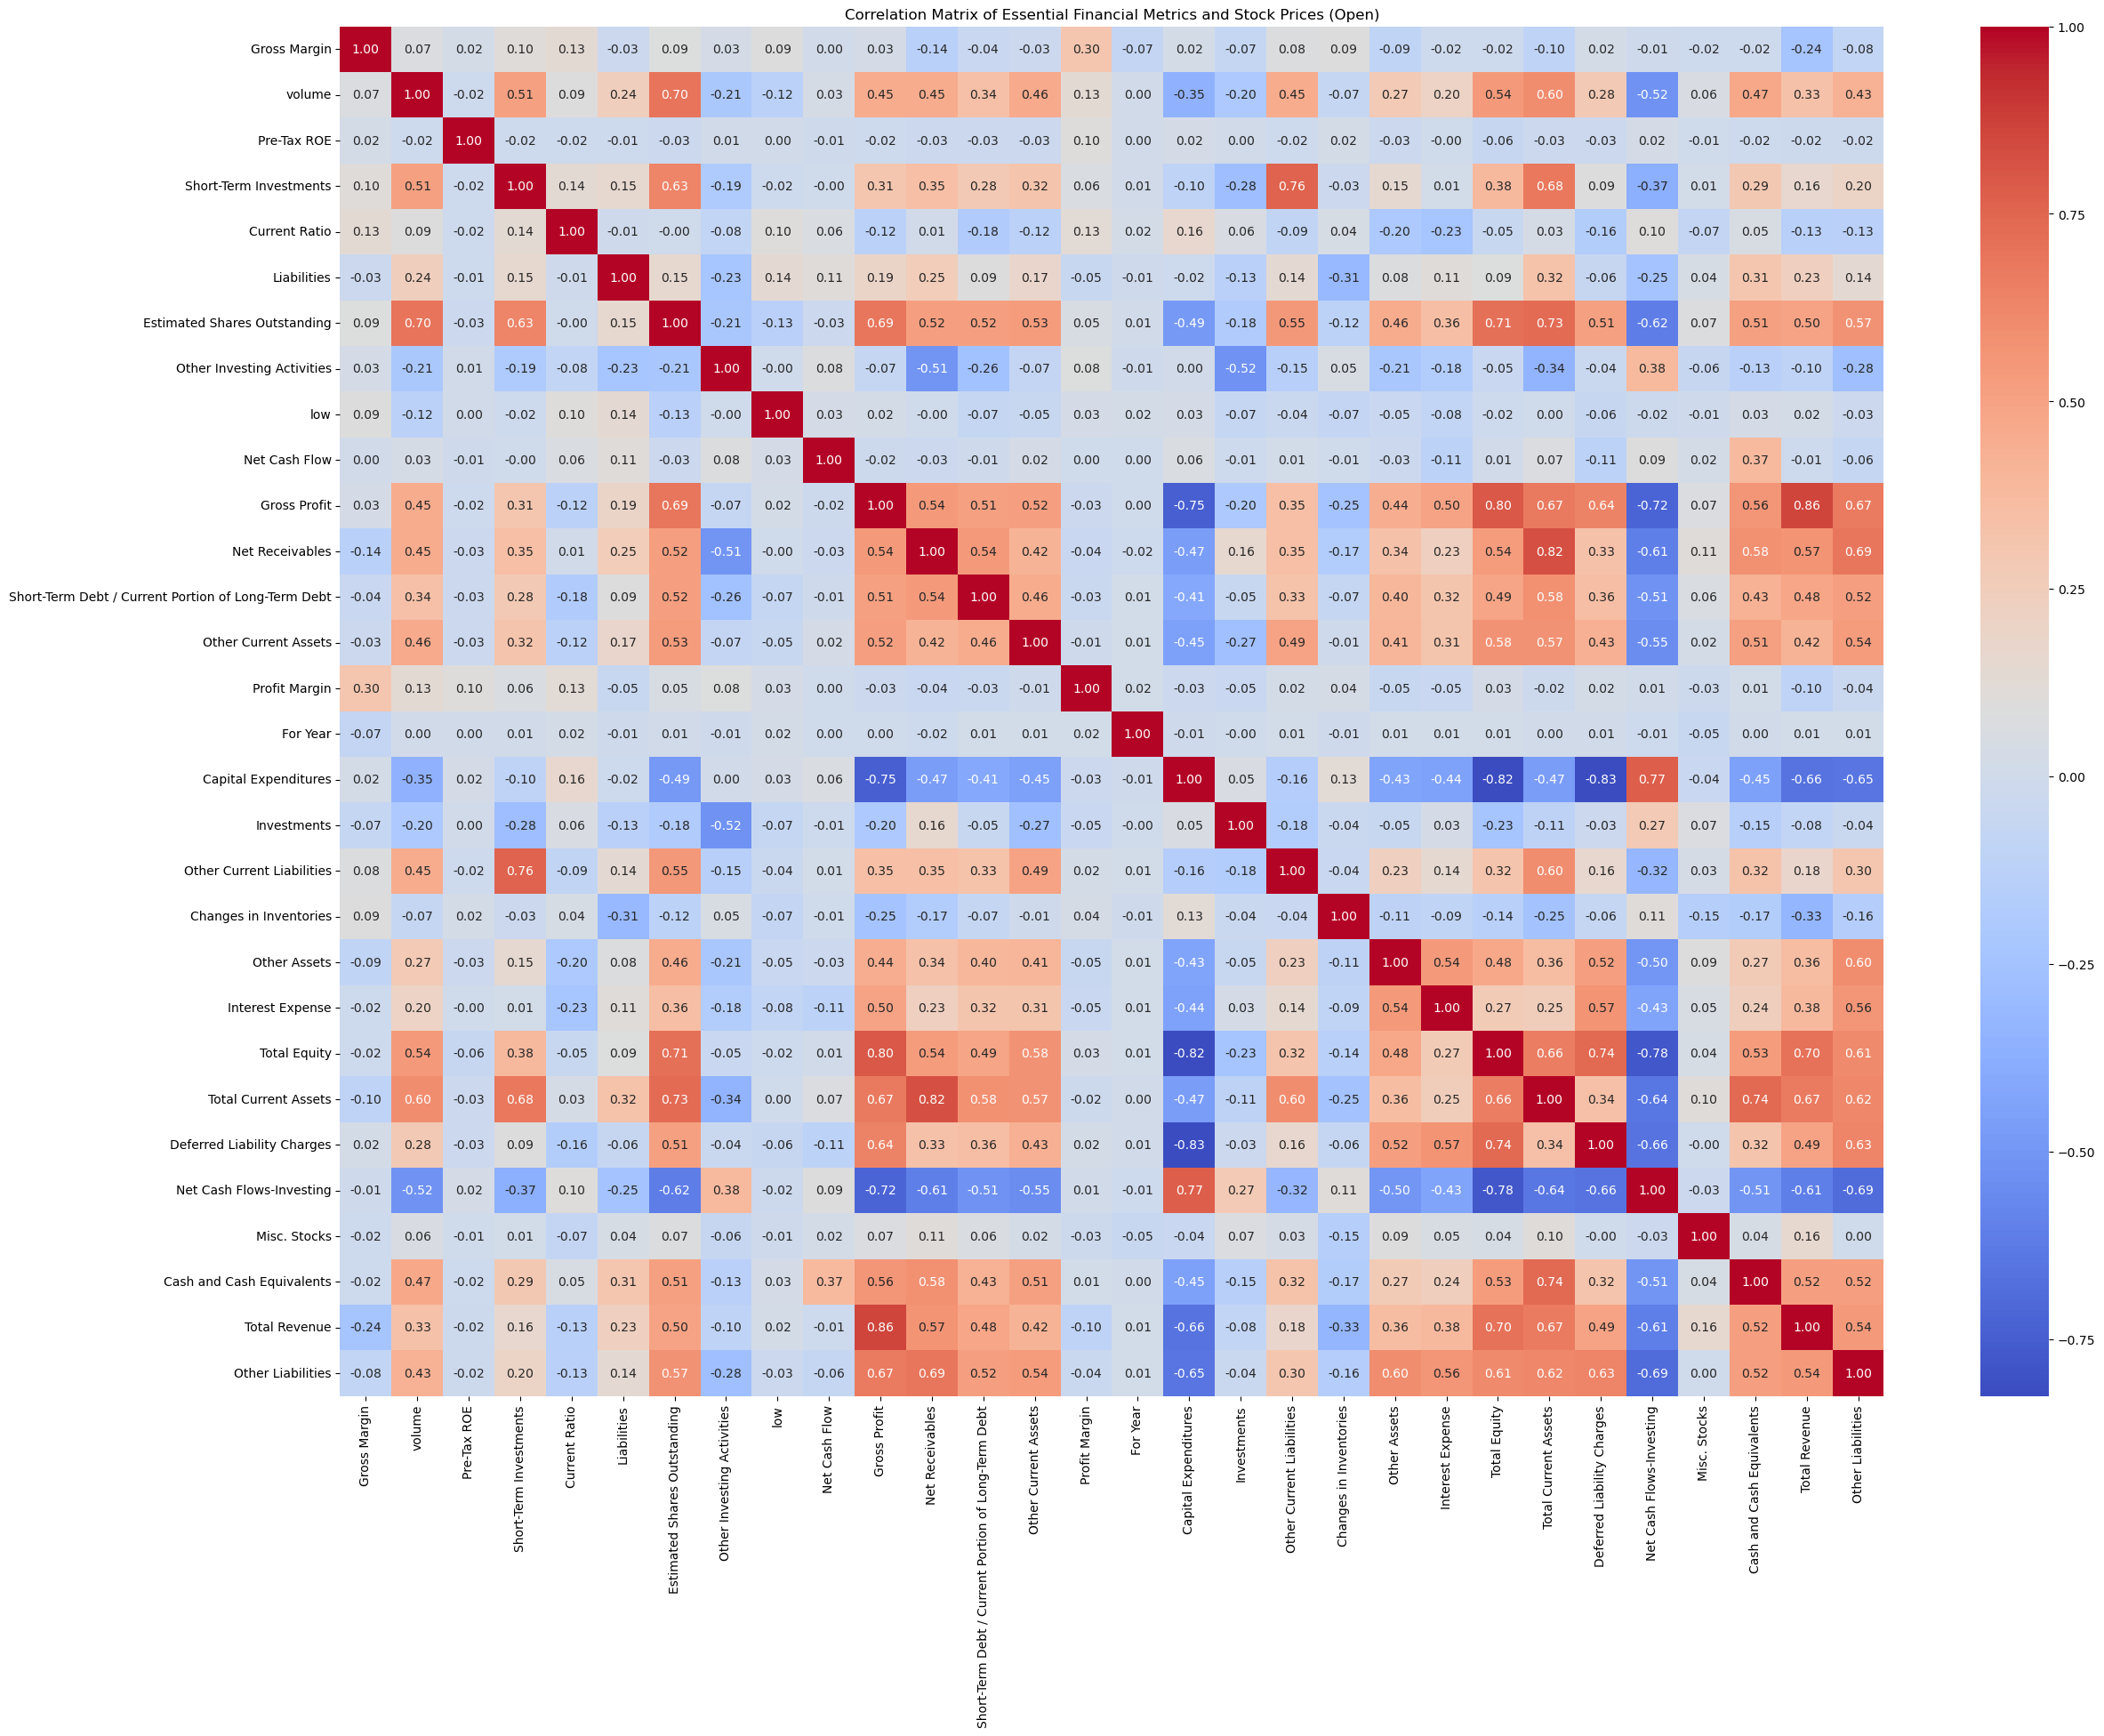

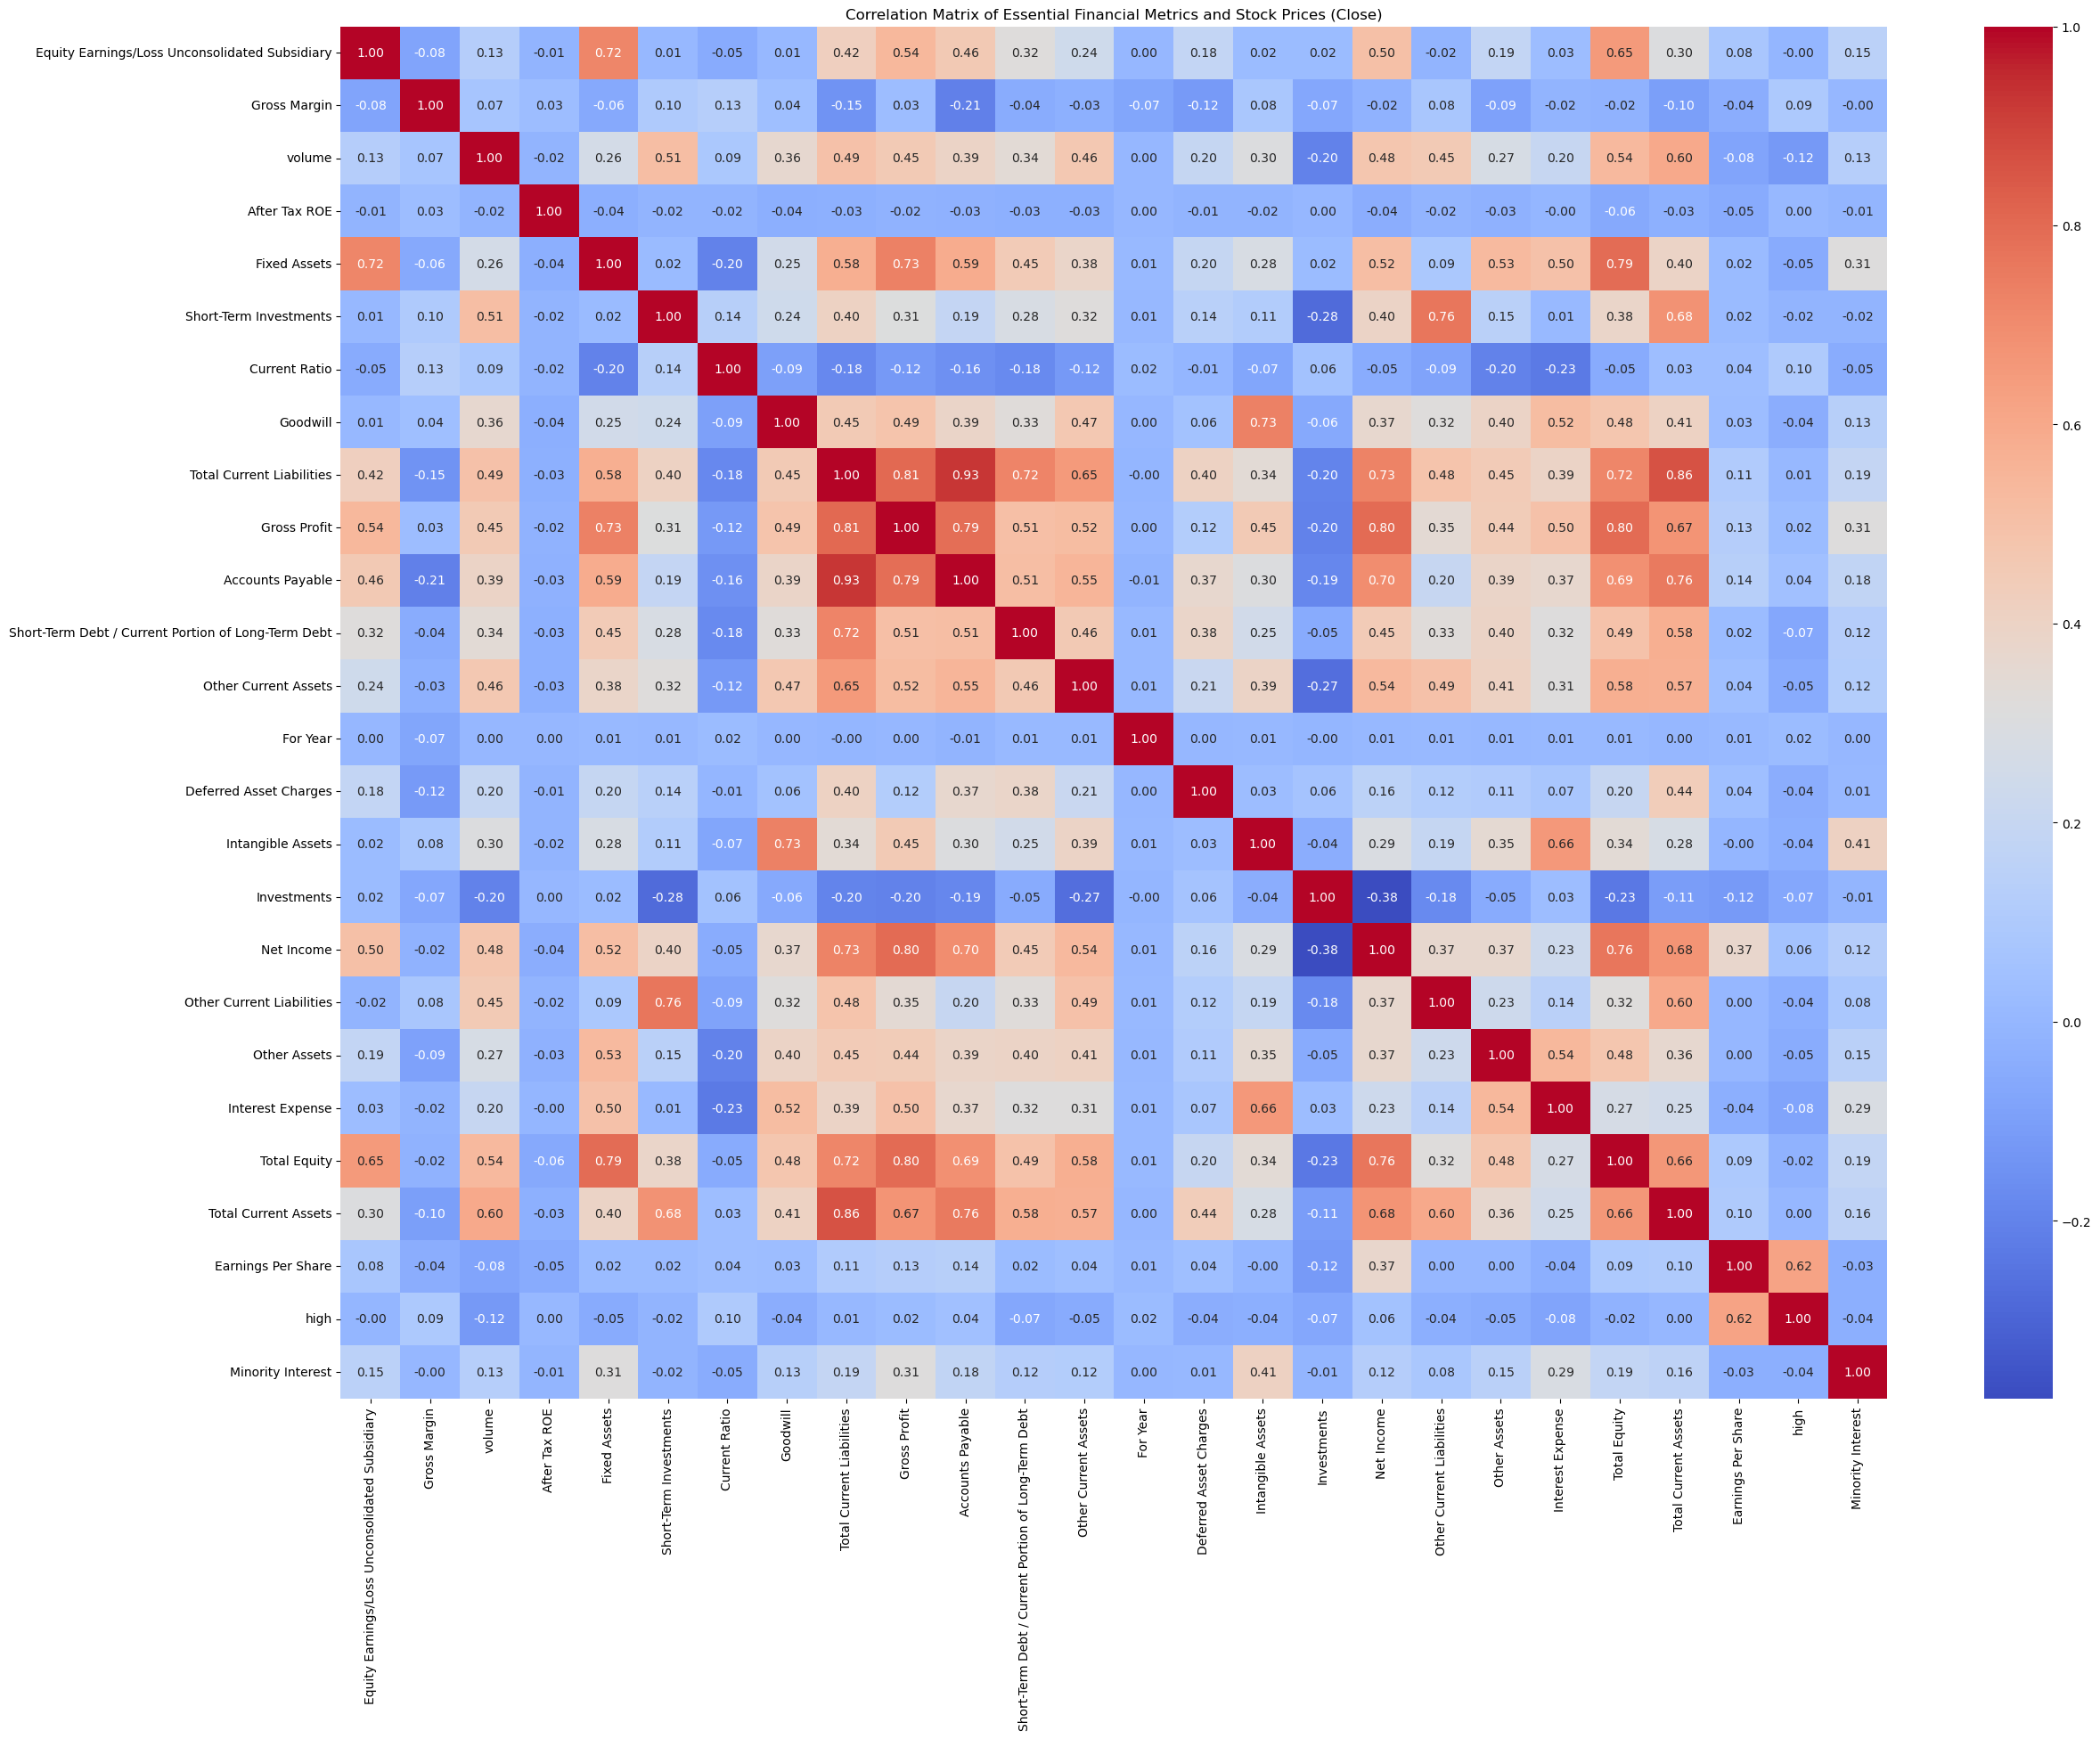

In [20]:
# Filter the aligned data for essential columns only for both open and close prices
selected_data_open = aligned_data_cleaned[list(common_features_open)]
selected_data_close = aligned_data_cleaned[list(common_features_close)]

# Remove Correlated Features For Open - Pre-tax Margin and Cost of Revenue, High
selected_data_open = selected_data_open.drop(columns=['Pre-Tax Margin', 'Cost of Revenue', 'high'])
# Remove Correlated Features For Close - Earnings Before Tax, Earnings Before Interest and Tax, Net Income Applicable to Common Shareholders, Low
selected_data_close = selected_data_close.drop(columns=['Earnings Before Interest and Tax', 'Net Income Applicable to Common Shareholders', 'low', 'Earnings Before Tax'])

# Remaining Features
print('Remaining features (open): ', len(selected_data_open.columns))
print('Remaining features (close): ', len(selected_data_close.columns))


# Calculate the correlation matrix for the selected data
correlation_matrix_open = selected_data_open.corr()
correlation_matrix_close = selected_data_close.corr()


# Visualize the correlation matrices using a heatmap
plt.figure(figsize=(28, 20))
sns.heatmap(correlation_matrix_open, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices (Open)")
plt.show()
plt.figure(figsize=(28, 20))
sns.heatmap(correlation_matrix_close, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices (Close)")
plt.show()



## Data Visuaualization
---
The following code visualizes the selected features and their relationships with the target variables (open and close prices). The visualizations include scatter plots, correlation heatmaps, and pair plots. The visualizations help to understand the relationships between the features and the target variables, and to identify any patterns or trends that may be useful for predicting stock prices.





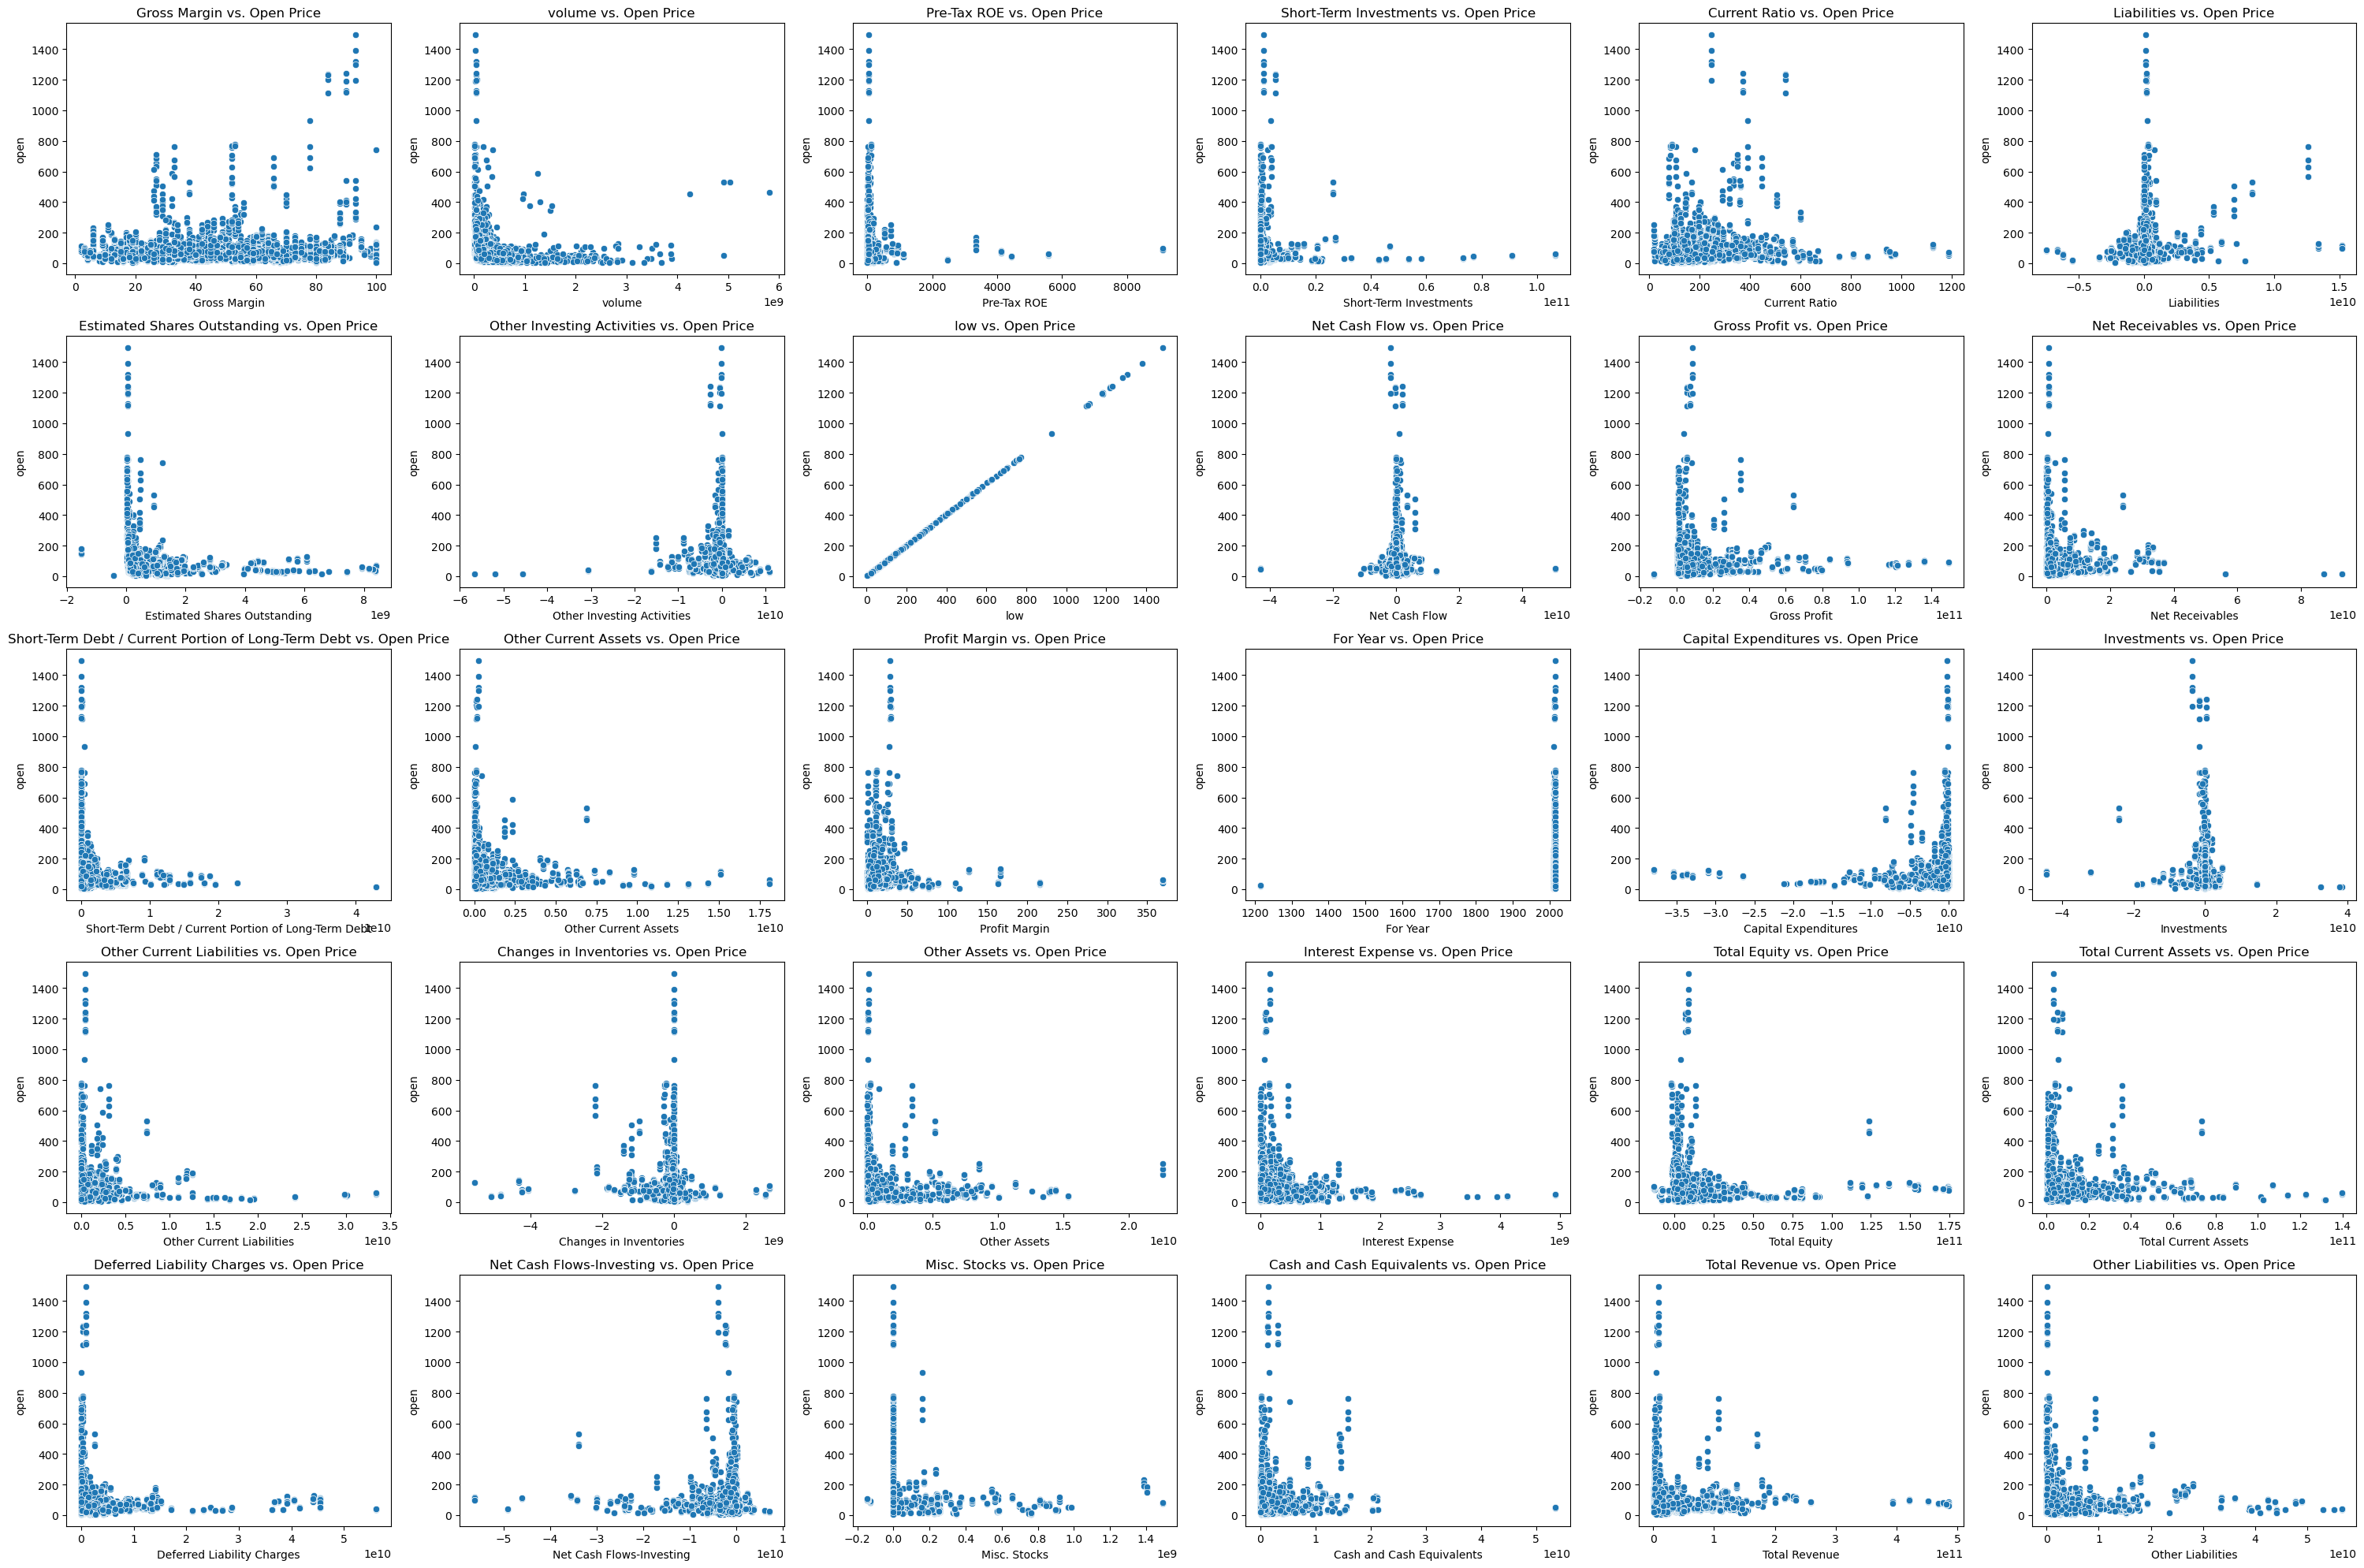

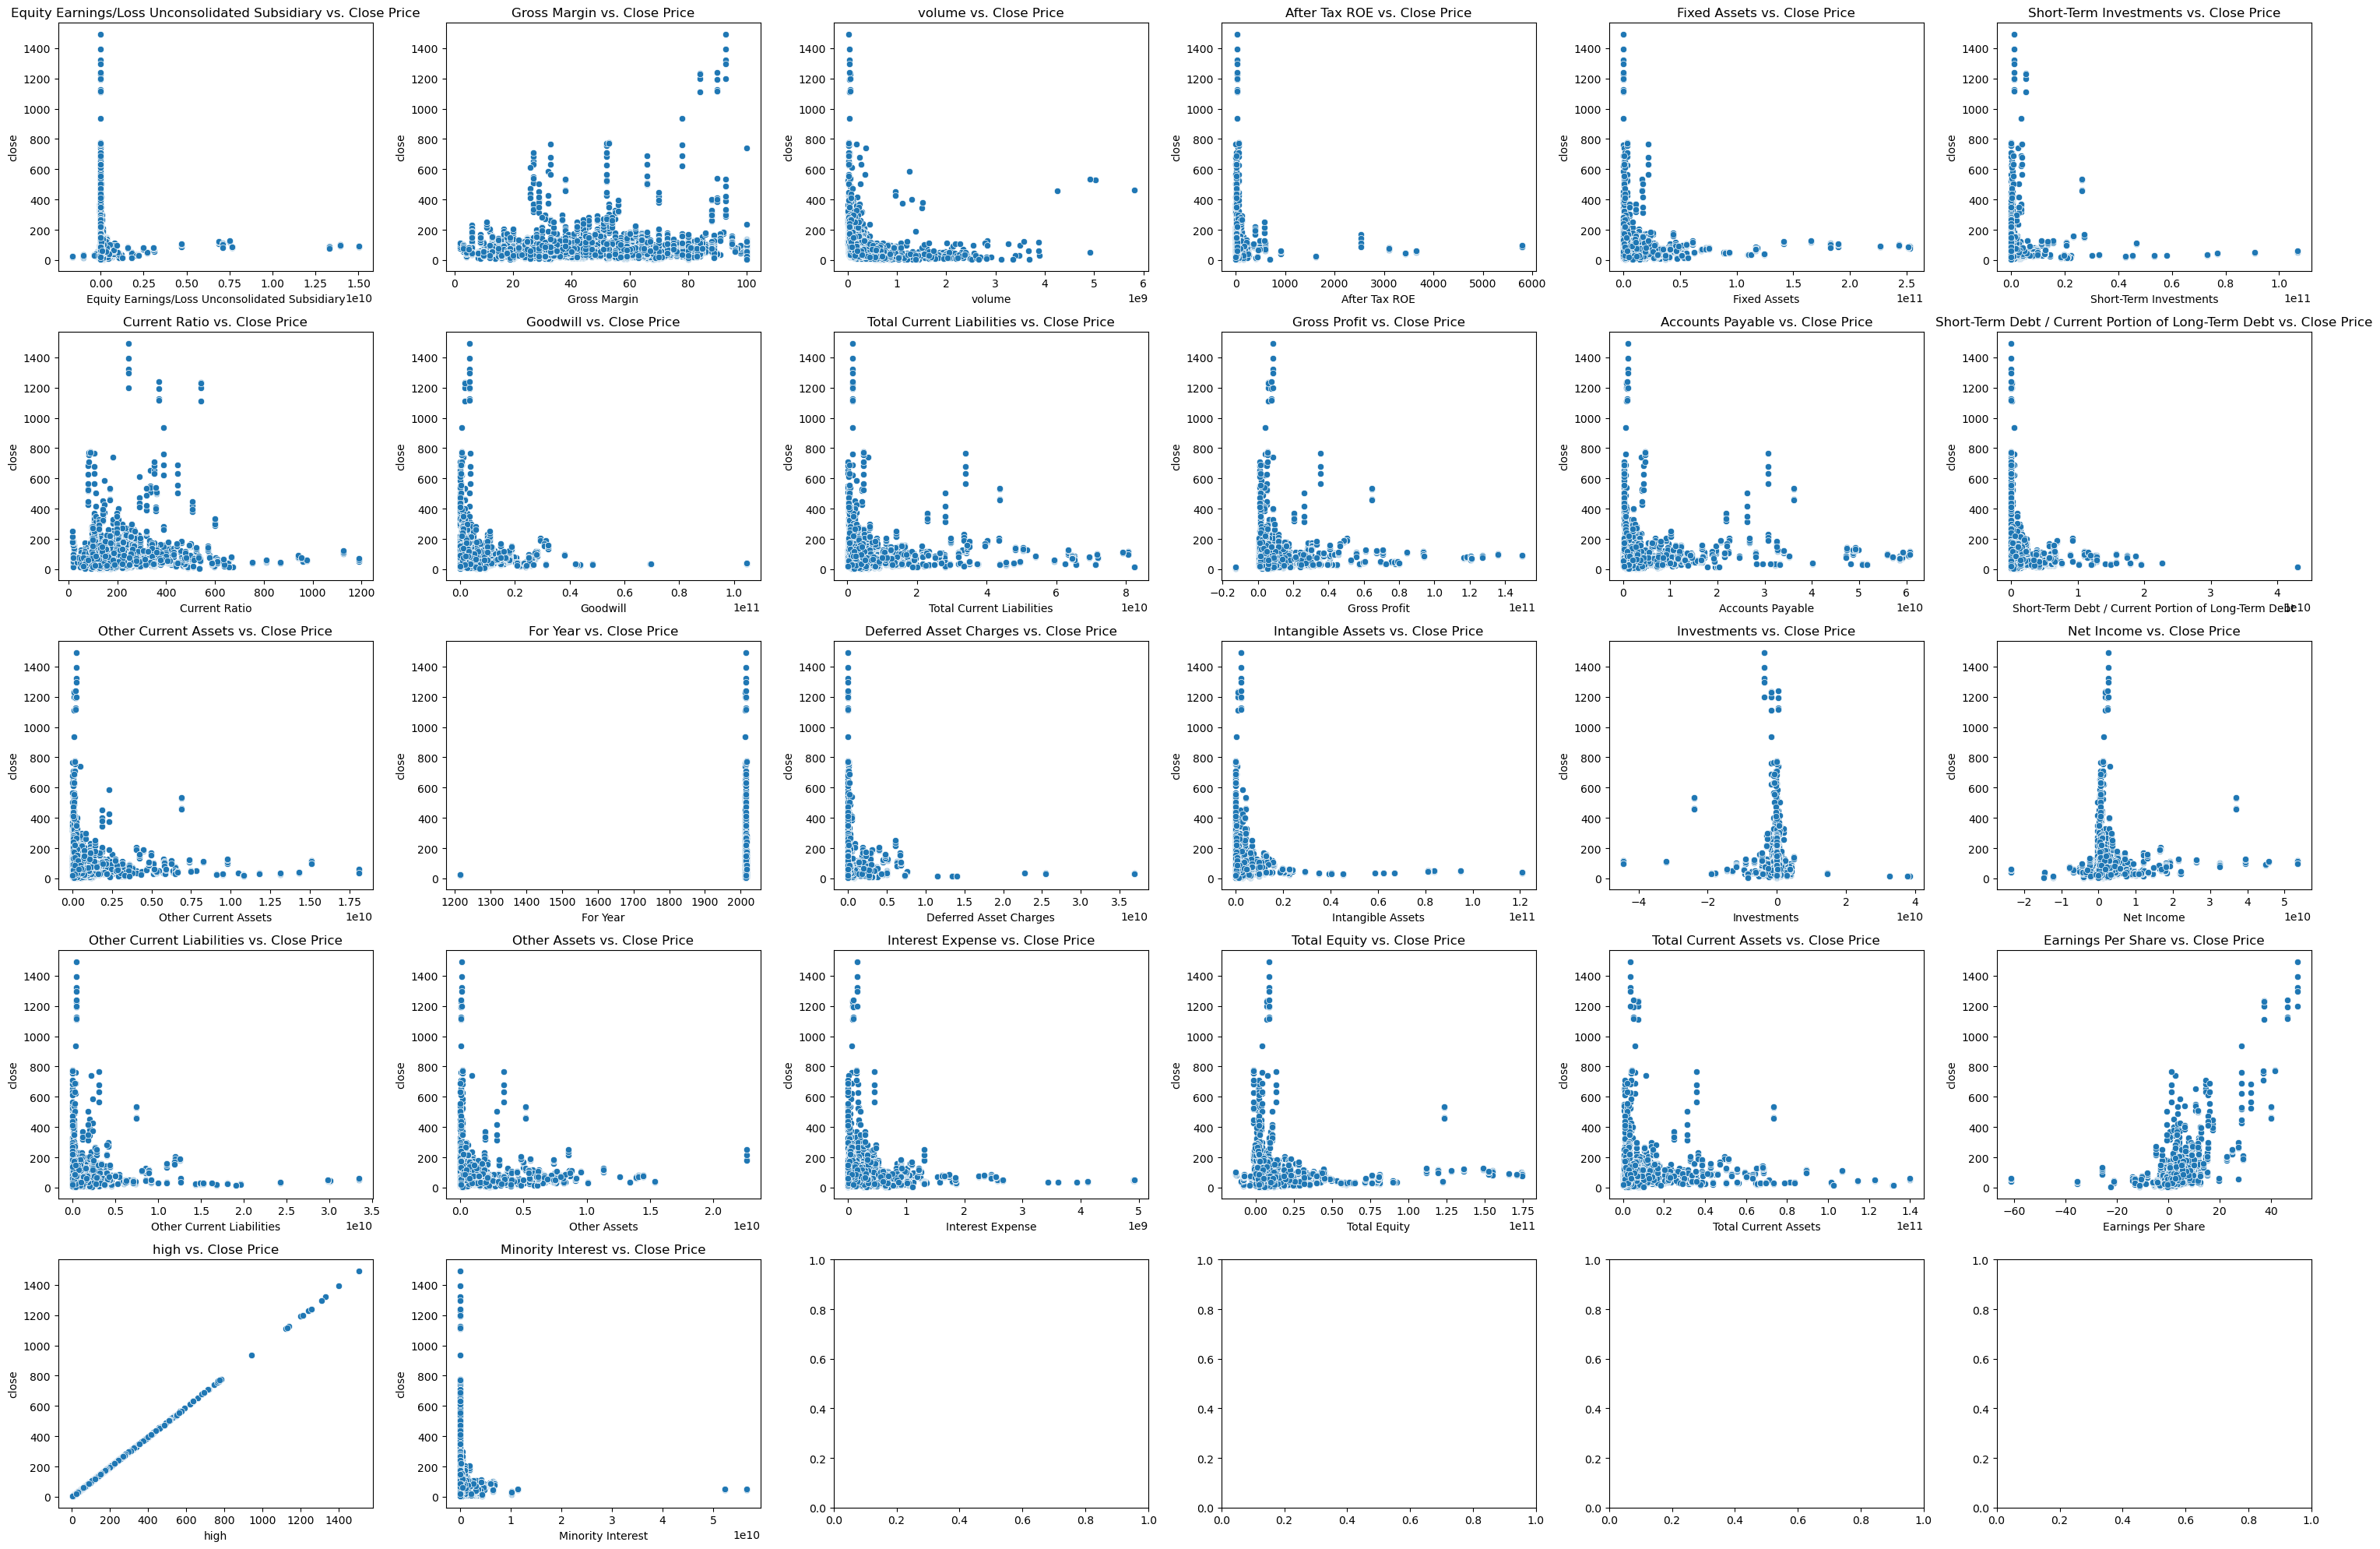

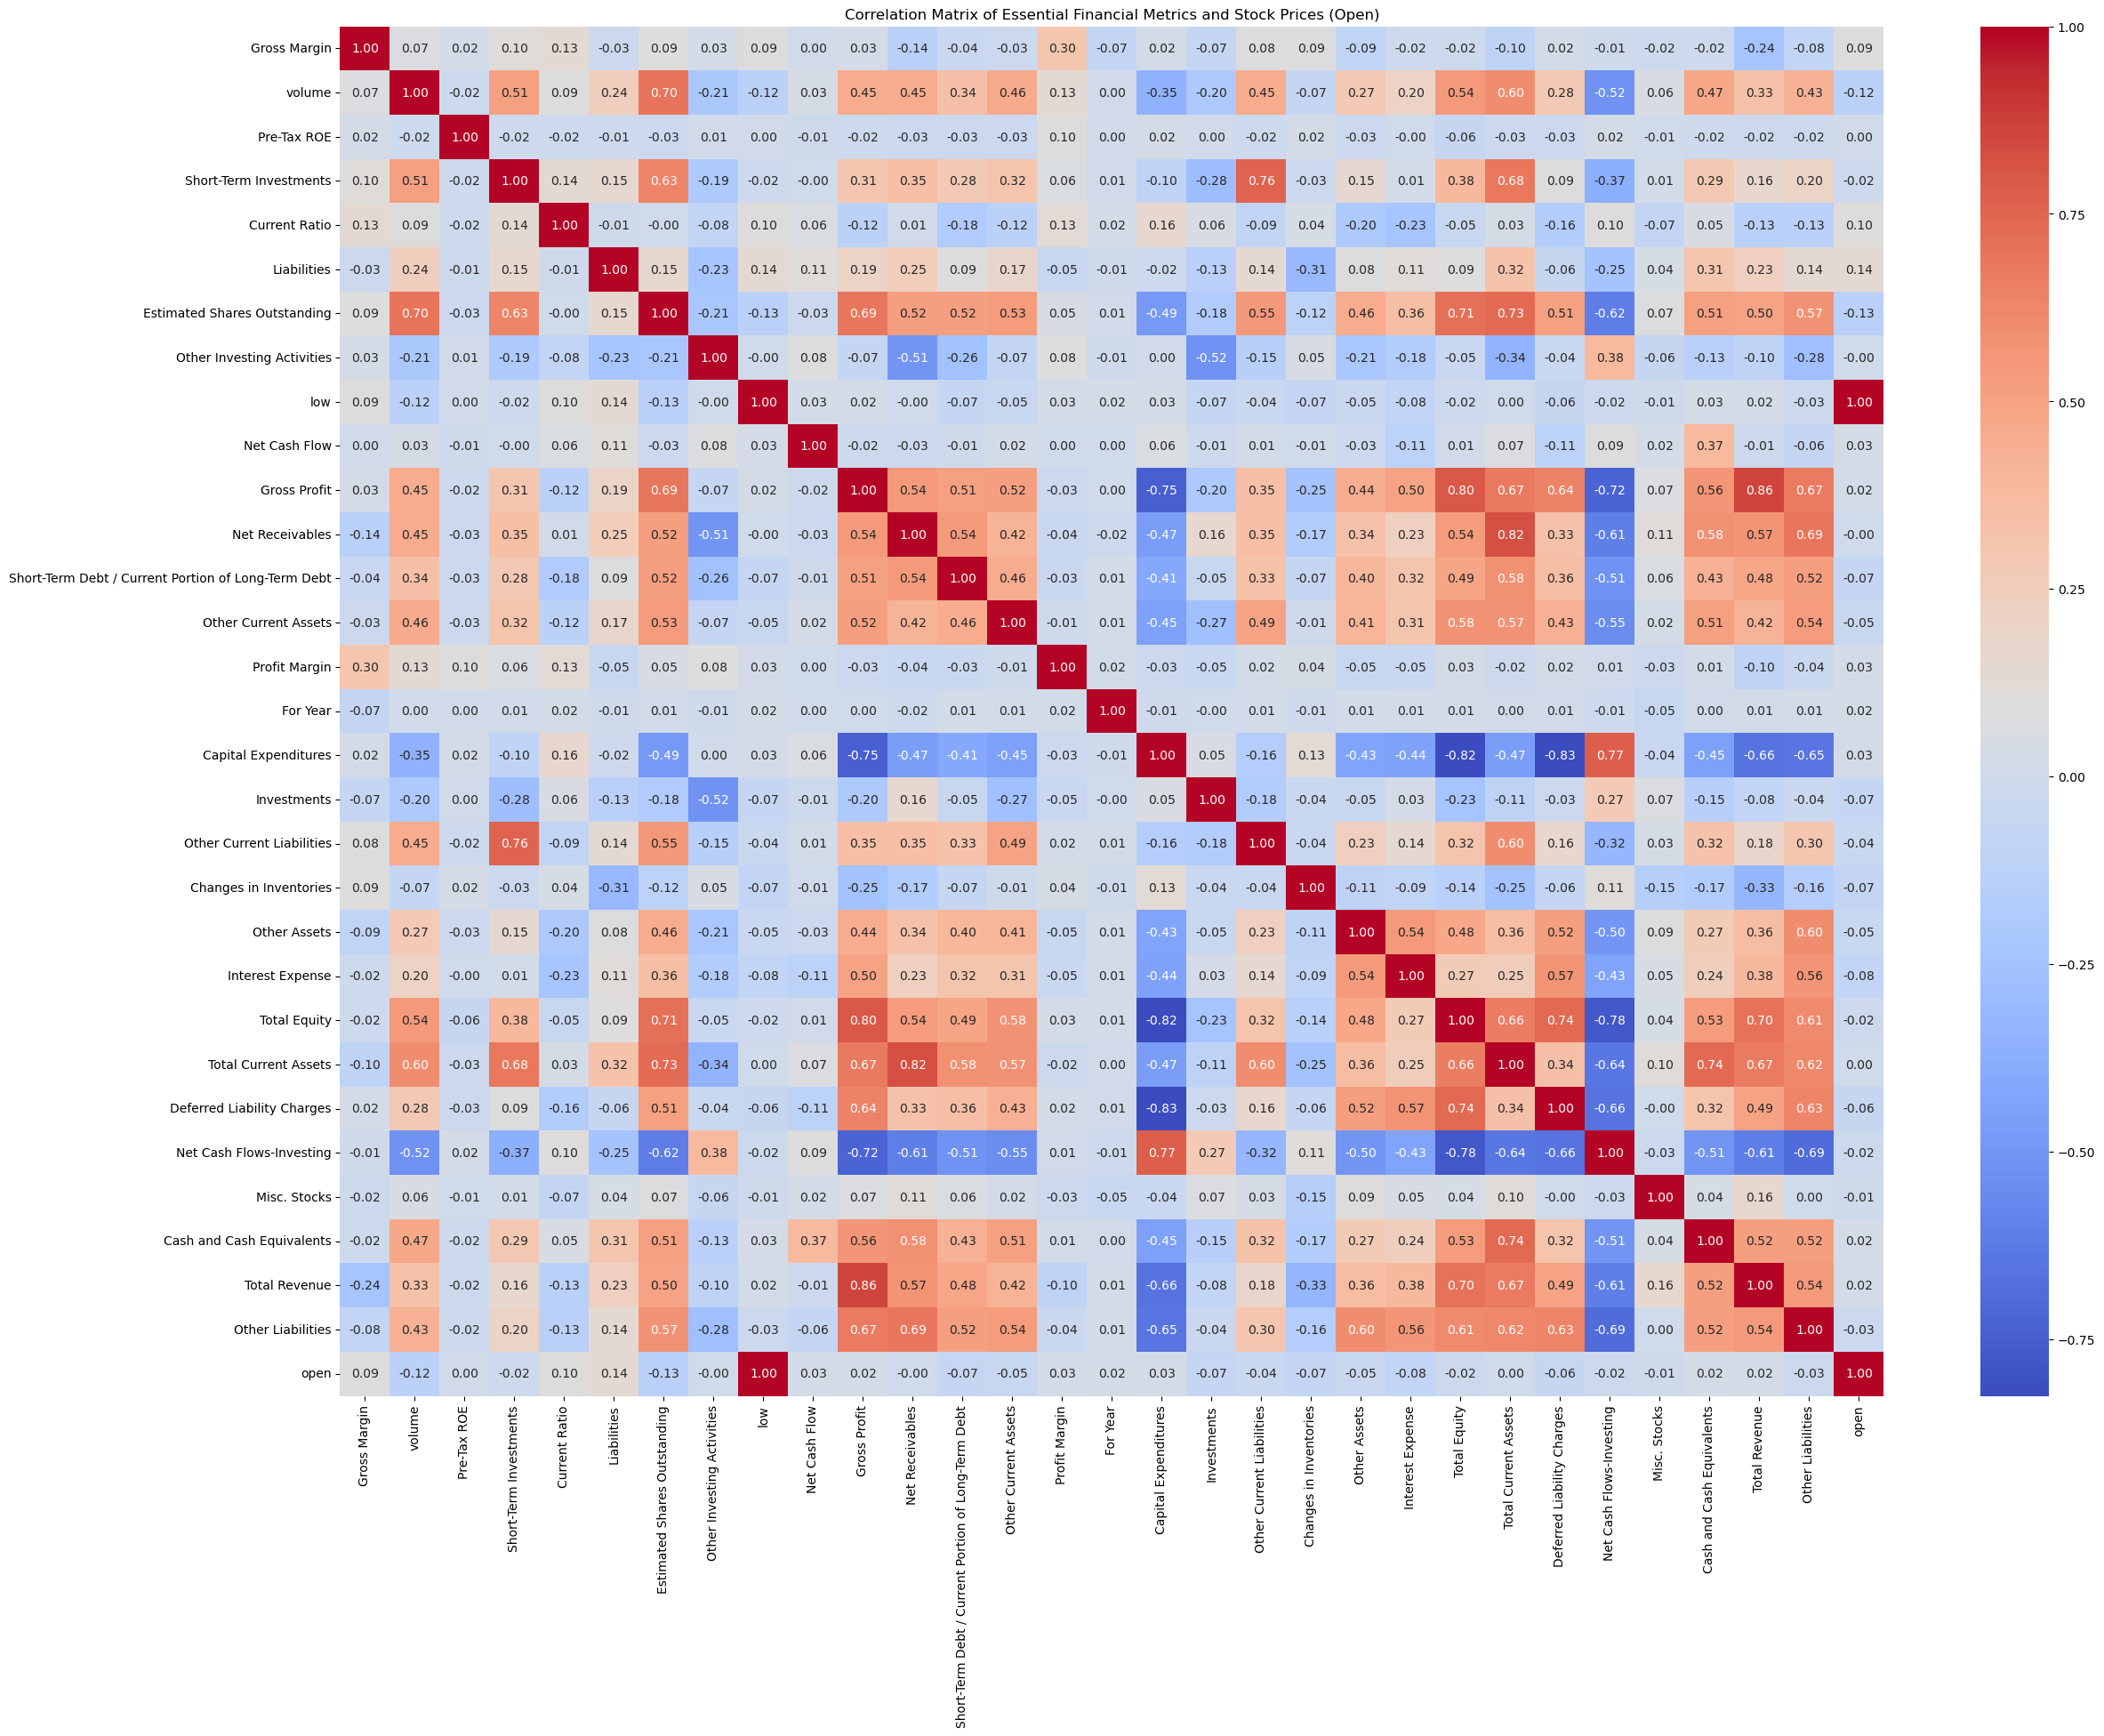

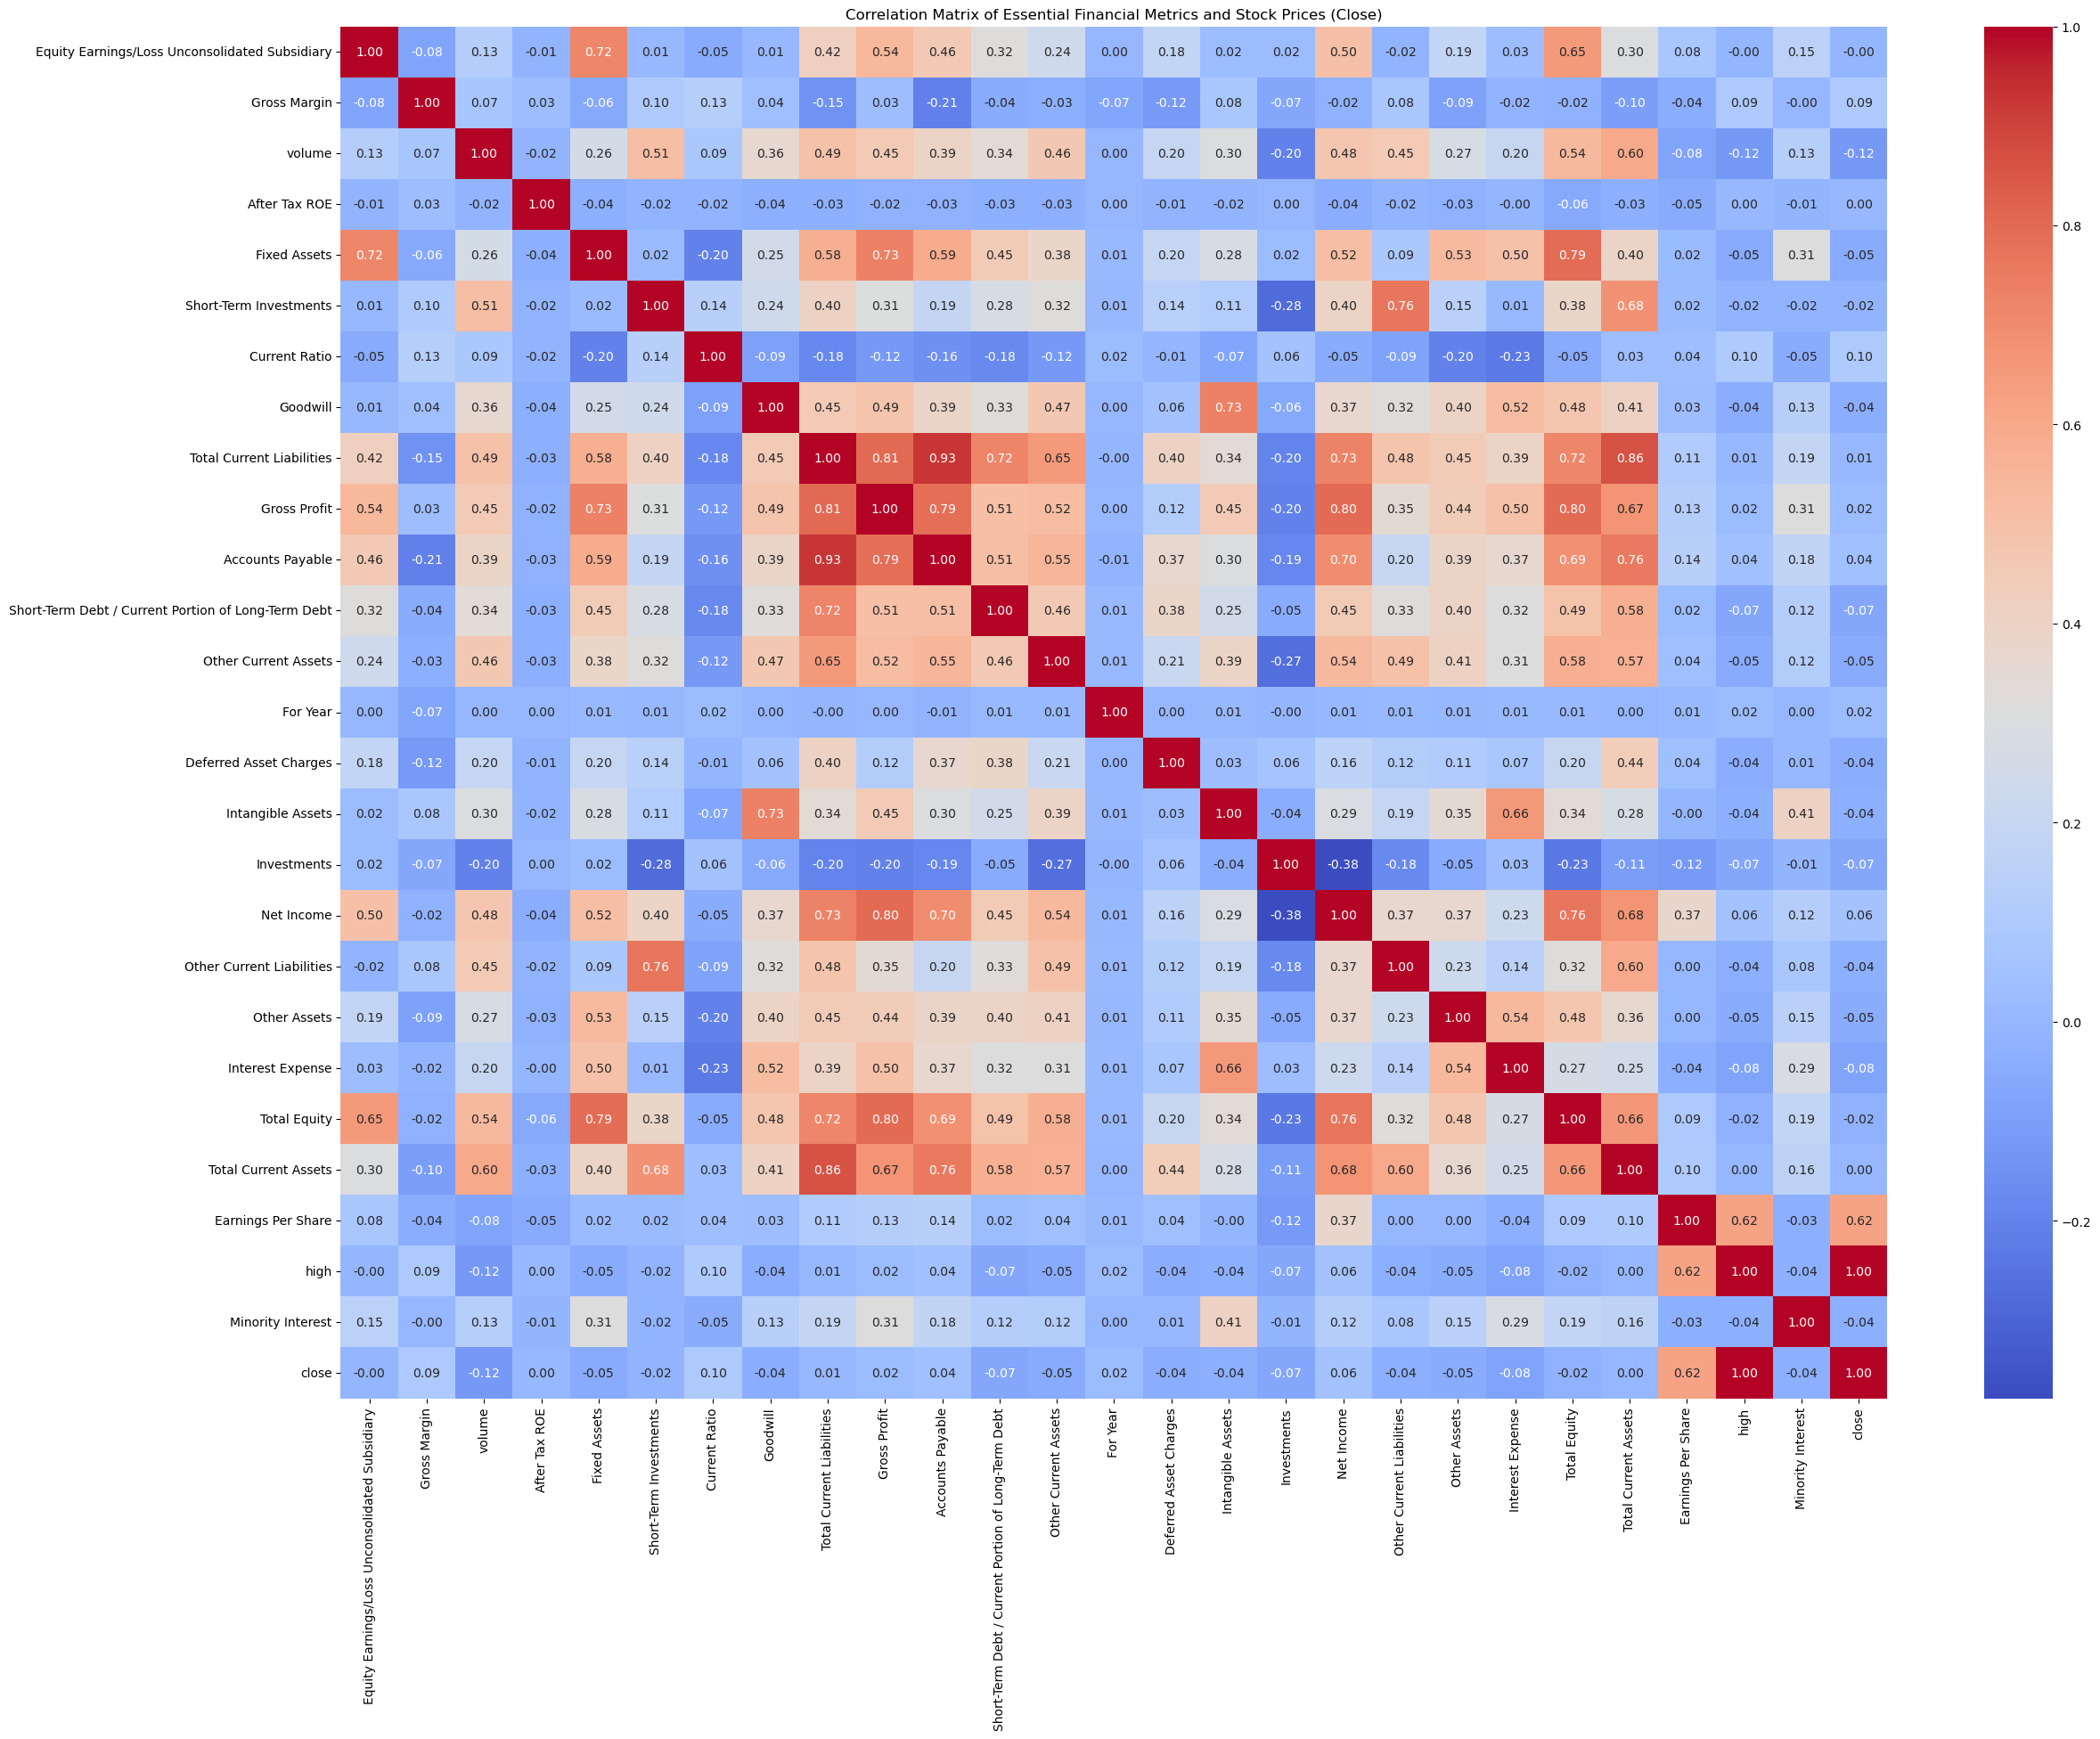

Histograms: Open


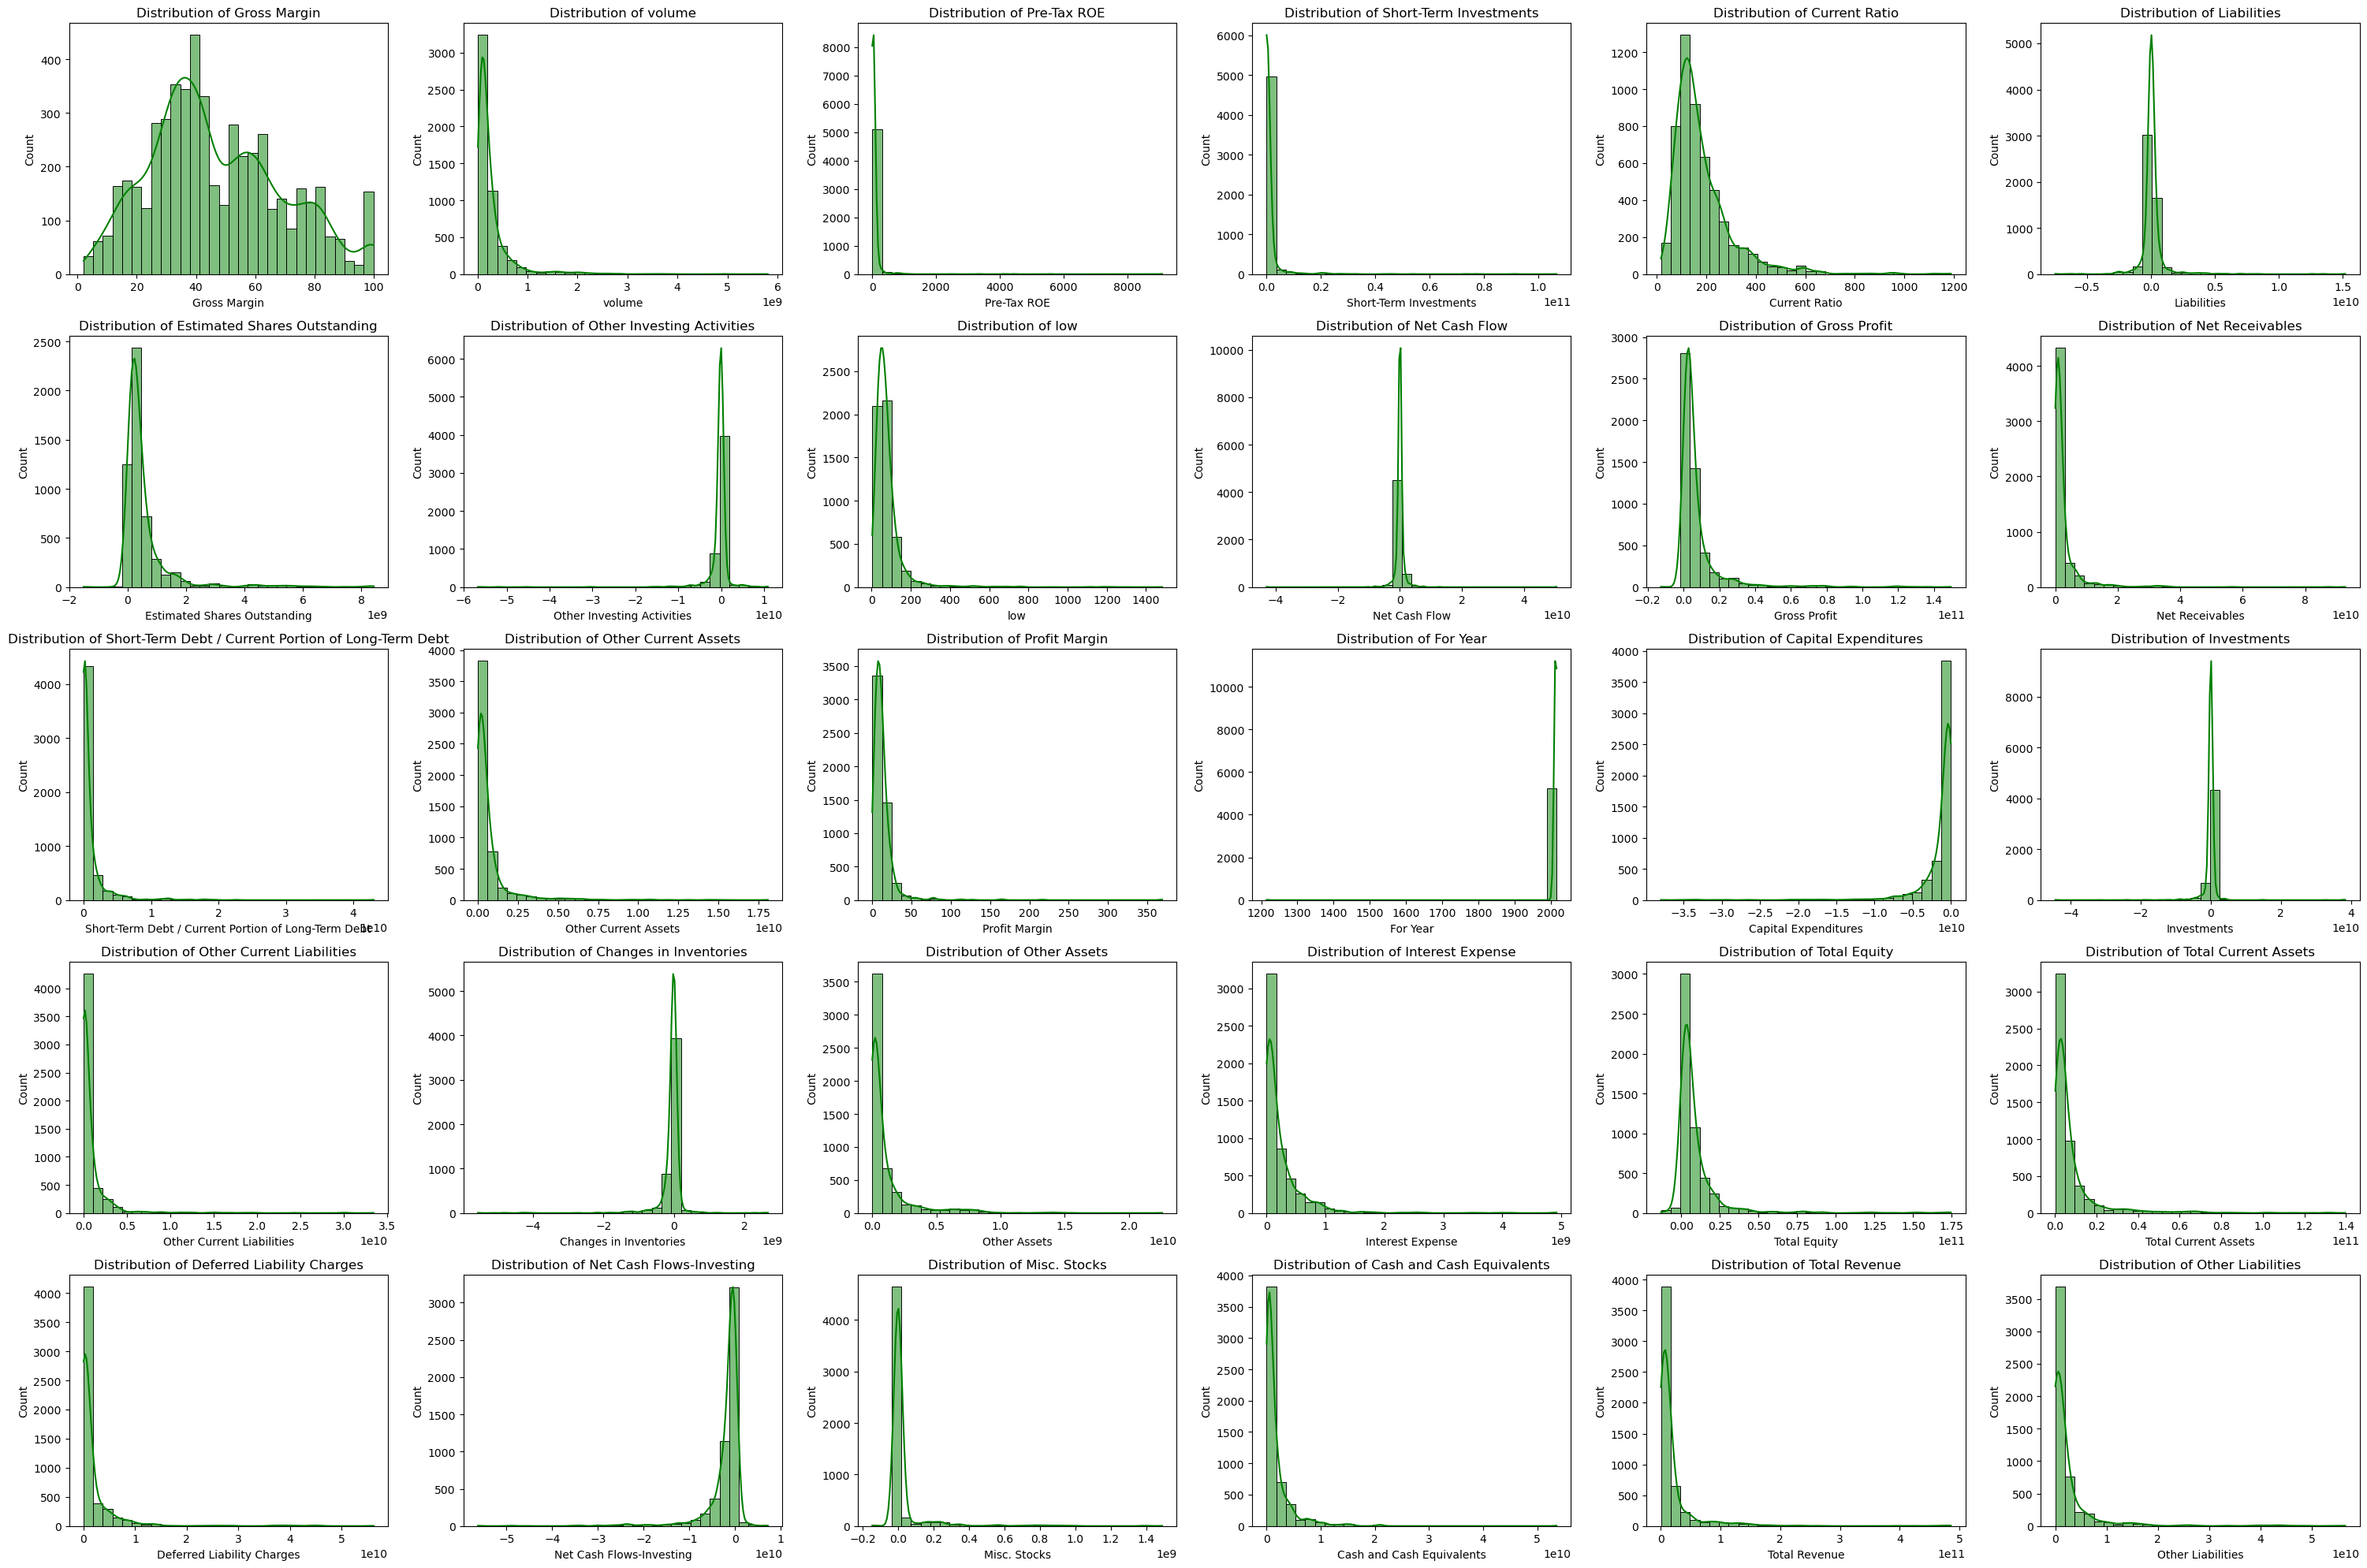

Histograms: Close


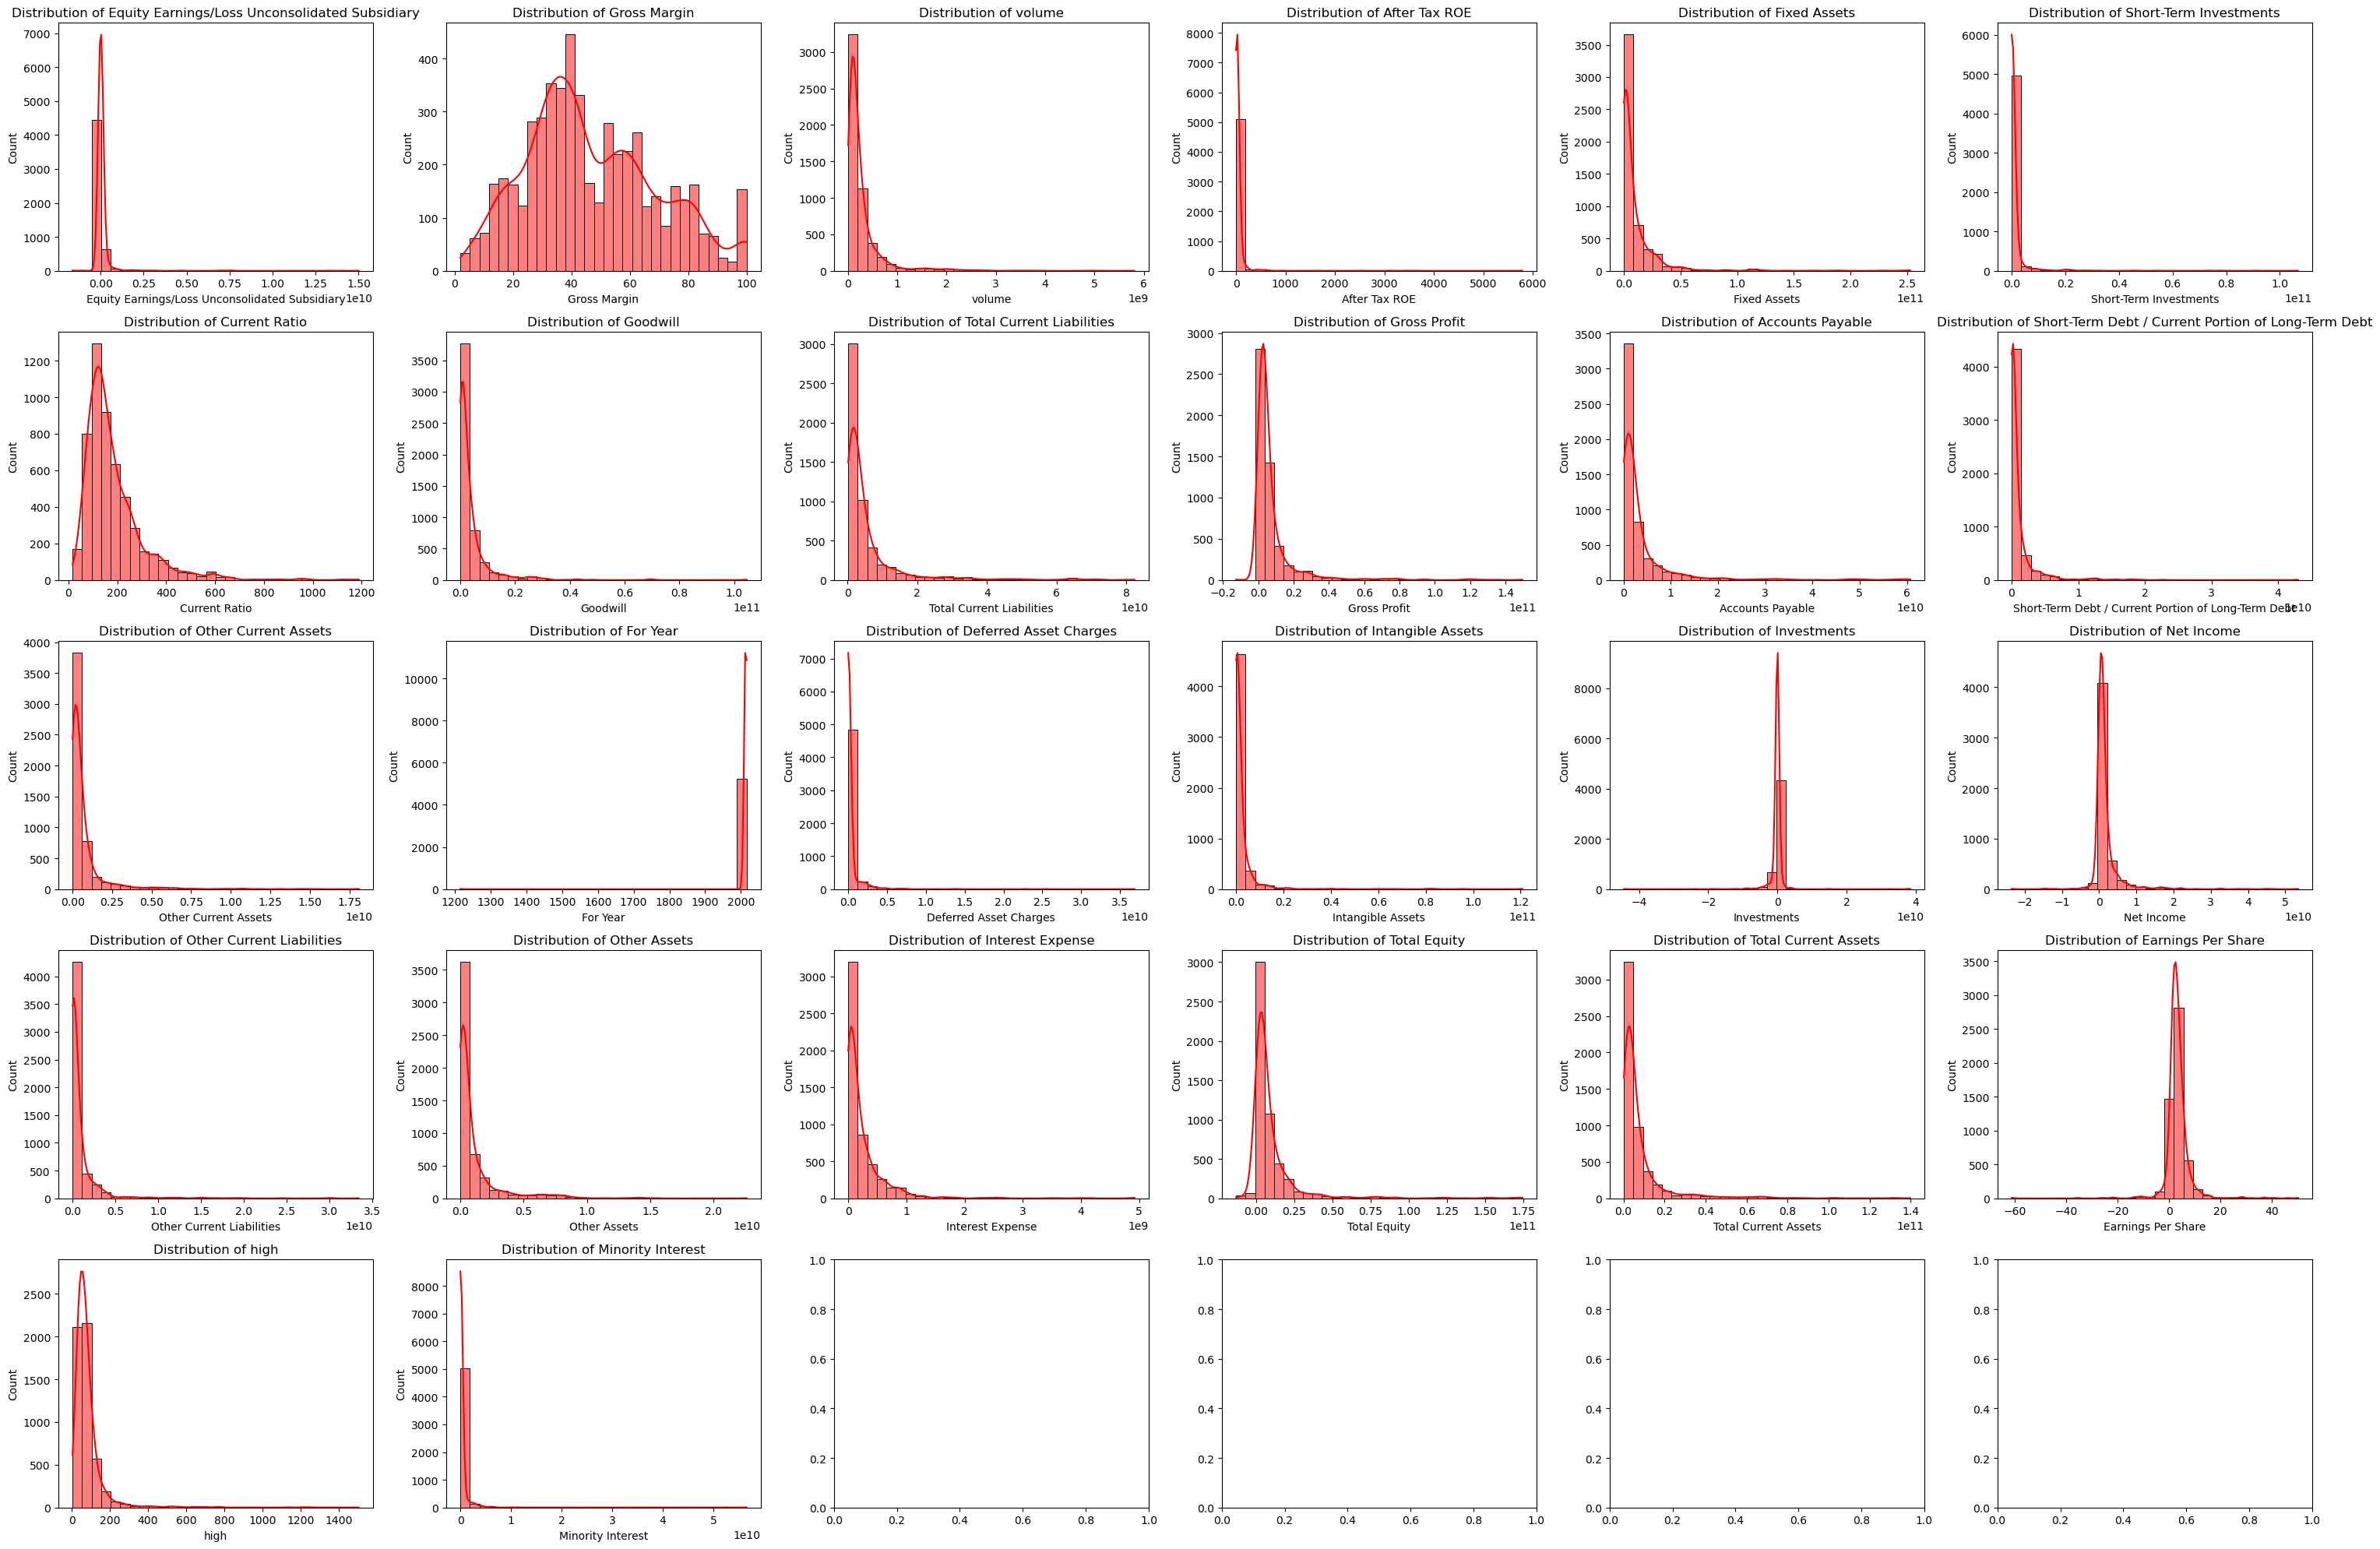

In [22]:
# Mark all open and close essential columns for analysis
# essential_columns = [
#     'open', 'close', 'high', 'low', 'Earnings Per Share', 'Liabilities', 'Cash Ratio', 'Quick Ratio', 
#     'Current Ratio', 'Gross Margin', 'Period Ending', 'date', 'Operating Income', 'Earnings Before Tax',
#     'Net Income Applicable to Common Shareholders', 'Net Income', 'Net Income-Cont. Operations', 'Income Tax', 
#     'Earnings Before Interest and Tax', 'Other Current Assets', 'Fixed Assets', 'Deferred Liability Charges',
#     'Sale and Purchase of Stock', 'Accounts Receivable', 'Long-Term Debt', 'Non-Recurring Items',
#     'Short-Term Debt / Current Portion of Long-Term Debt', 'Investments', 'Changes in Inventories',
#     'Interest Expense', 'Capital Surplus', 'volume', 'Estimated Shares Outstanding'
# ]

# # Filter the aligned data for essential columns only
# selected_data = aligned_data_cleaned[essential_columns]

# # Display a preview of the selected data
# print(selected_data.head())


# # Plot distribution of a few key financial metrics
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# sns.histplot(aligned_data['Earnings Per Share'], bins=30, kde=True, ax=axes[0, 0])
# axes[0, 0].set_title("Distribution of Earnings Per Share")

# sns.histplot(aligned_data['Total Liabilities'], bins=30, kde=True, ax=axes[0, 1])
# axes[0, 1].set_title("Distribution of Total Liabilities")

# sns.histplot(aligned_data['Capital Surplus'], bins=30, kde=True, ax=axes[1, 0])
# axes[1, 0].set_title("Distribution of Capital Surplus")

# sns.histplot(aligned_data['Estimated Shares Outstanding'], bins=30, kde=True, ax=axes[1, 1])
# axes[1, 1].set_title("Distribution of Estimated Shares Outstanding")

# plt.tight_layout()
# plt.show()

# selected_data = aligned_data_cleaned[['symbol'] + essential_columns]
# print(selected_data.head())
# print('shape:', selected_data.shape)

# =============================================================================

# Get Selected Data for Open and Close Prices
final_data_open = aligned_data_cleaned[['symbol'] + list(selected_data_open.columns) + ['open']]
final_data_close = aligned_data_cleaned[['symbol'] + list(selected_data_close.columns) + ['close']]

# SCATTER PLOTS ----------------------------------------------

# Plot scatter plots of selected features against open and close prices
# Open - 30 features
# Close - 26 features
fig, axes = plt.subplots(5, 6, figsize=(30, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, feature in enumerate(selected_data_open.columns):
    sns.scatterplot(x=feature, y='open', data=final_data_open, ax=axes[i // 6, i % 6])
    axes[i // 6, i % 6].set_title(f"{feature} vs. Open Price")
    
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(5, 6, figsize=(30, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, feature in enumerate(selected_data_close.columns):
    sns.scatterplot(x=feature, y='close', data=final_data_close, ax=axes[i // 6, i % 6])
    axes[i // 6, i % 6].set_title(f"{feature} vs. Close Price")
    
plt.tight_layout()
plt.show()
    
    
# Correlation Heatmaps ----------------------------------------------
# Open
correlation_matrix_open = final_data_open.drop(columns=['symbol']).corr()
plt.figure(figsize=(28, 20))
sns.heatmap(correlation_matrix_open, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices (Open)")
plt.show()

# Close
correlation_matrix_close = final_data_close.drop(columns=['symbol']).corr()
plt.figure(figsize=(28, 20))
sns.heatmap(correlation_matrix_close, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices (Close)")
plt.show()


# Histograms ----------------------------------------------

# Plot histograms of selected features
# Open - 30 features
fig, axes = plt.subplots(5, 6, figsize=(30, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

print("Histograms: Open")
for i, feature in enumerate(selected_data_open.columns):
    sns.histplot(final_data_open[feature], bins=30, kde=True, ax=axes[i // 6, i % 6], color='green')
    axes[i // 6, i % 6].set_title(f"Distribution of {feature}")
    
plt.tight_layout()
plt.show()

# Close - 26 features
print("Histograms: Close")
fig, axes = plt.subplots(5, 6, figsize=(30, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, feature in enumerate(selected_data_close.columns):
    sns.histplot(final_data_close[feature], bins=30, kde=True, ax=axes[i // 6, i % 6], color='red')
    axes[i // 6, i % 6].set_title(f"Distribution of {feature}")
    
plt.tight_layout()
plt.show()



In [23]:
# securities_df = pd.read_csv('data/securities.csv')
# securities_selected = securities_df[['Ticker symbol', 'GICS Sector', 'GICS Sub Industry']]

# final_df = selected_data.merge(securities_selected, left_on='symbol', right_on='Ticker symbol', how='left')

# final_df.drop(columns=['Ticker symbol'], inplace=True)
# print(final_df.head())
# final_df.shape

final_df_open = final_data_open.drop(columns=['symbol'])
final_df_close = final_data_close.drop(columns=['symbol'])
final_df_with_symbols_open = final_data_open
final_df_with_symbols_close = final_data_close
print('Final Dataframe Shape With Symbol (Open): ', final_df_with_symbols_open.shape)
print('Final Dataframe Shape With Symbol (Close): ', final_df_with_symbols_close.shape)
print('Final Dataframe Shape (Open): ', final_df_open.shape)
print('Final Dataframe Shape (Close): ', final_df_close.shape)
print('Open Features: ',final_df_open.columns)
print('Close Features: ', final_df_close.columns)


Final Dataframe Shape With Symbol (Open):  (5243, 32)
Final Dataframe Shape With Symbol (Close):  (5243, 28)
Final Dataframe Shape (Open):  (5243, 31)
Final Dataframe Shape (Close):  (5243, 27)
Open Features:  Index(['Gross Margin', 'volume', 'Pre-Tax ROE', 'Short-Term Investments',
       'Current Ratio', 'Liabilities', 'Estimated Shares Outstanding',
       'Other Investing Activities', 'low', 'Net Cash Flow', 'Gross Profit',
       'Net Receivables',
       'Short-Term Debt / Current Portion of Long-Term Debt',
       'Other Current Assets', 'Profit Margin', 'For Year',
       'Capital Expenditures', 'Investments', 'Other Current Liabilities',
       'Changes in Inventories', 'Other Assets', 'Interest Expense',
       'Total Equity', 'Total Current Assets', 'Deferred Liability Charges',
       'Net Cash Flows-Investing', 'Misc. Stocks', 'Cash and Cash Equivalents',
       'Total Revenue', 'Other Liabilities', 'open'],
      dtype='object')
Close Features:  Index(['Equity Earnings/Lo

In [24]:
######IMPLEMENTATION######

# import necessary libs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# helper funcs
def predict(X, theta, degree):
    X_poly = add_polynomial_features(X, degree)
    return X_poly.dot(theta)

def add_polynomial_features(X, degree):
    X_poly = np.ones((X.shape[0], 1))  # Start with a column of ones (for the intercept)
    for d in range(1, degree + 1):
        X_poly = np.hstack((X_poly, X ** d))  # Add each polynomial degree column
    return X_poly

def polynomial_regression(X, y, degree, learning_rate, n_iterations, alpha, max_gradient=1e4):
    X_poly = add_polynomial_features(X, degree)
    y = y.reshape(-1, 1)
    m, n = X_poly.shape

    # Initialize theta (parameter vector) with zeros
    theta = np.zeros((n, 1))

    # Gradient descent
    for i in range(n_iterations):
        predictions = X_poly.dot(theta)
        errors = predictions - y
        gradients = (2 / m) * X_poly.T.dot(errors) + (2 * alpha * theta)

        # Clip gradients to prevent excessively large updates
        gradients = np.clip(gradients, -max_gradient, max_gradient)

        # Update theta
        theta -= learning_rate * gradients

    return theta
    

In [25]:
# Func to run all models and output results
def train_and_evaluate_model(X, y, dataset_name):
    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = {}


    # SKLEARN LINEAR REGRESSION ----------------------------------------------

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results['Linear Regression'] = {'MSE': mse, 'R2': r2}

    print(f"{dataset_name} - Linear Regression")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()


    # SKLEARN POLYNOMIAL REGRESSION DEGREE 1 ----------------------------------------------

    poly1 = PolynomialFeatures(degree=1)
    X_train_poly1 = poly1.fit_transform(X_train_scaled)
    X_test_poly1 = poly1.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_poly1, y_train)
    y_pred = model.predict(X_test_poly1)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results['Polynomial Regression Degree 1'] = {'MSE': mse, 'R2': r2}

    print(f"{dataset_name} - Polynomial Regression Degree 1")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()


    # SKLEARN POLYNOMIAL REGRESSION DEGREE 2 ----------------------------------------------

    poly2 = PolynomialFeatures(degree=2)
    X_train_poly2 = poly2.fit_transform(X_train_scaled)
    X_test_poly2 = poly2.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_poly2, y_train)
    y_pred = model.predict(X_test_poly2)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results['Polynomial Regression Degree 2'] = {'MSE': mse, 'R2': r2}

    print(f"{dataset_name} - Polynomial Regression Degree 2")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    
    # CUSTOM POLYNOMIAL REGRESSION ----------------------------------------------

    custom_results = []
    # test polynomial degrees 1-3
    for degree in range(1, 4):  
        theta = polynomial_regression(
            X_train_scaled, y_train.values, degree=degree,
            learning_rate=0.001, n_iterations=10000, alpha=0.01
        )

        # ensure theta is valid
        if not np.isnan(theta).any():
            # predict on the test set
            y_pred = predict(X_test_scaled, theta, degree)

            # calculate eval metrics
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            custom_results.append((degree, mse, r2))
            results[f'Custom Polynomial Regression Degree {degree}'] = {'MSE': mse, 'R2': r2}

            print(f"{dataset_name} - Custom Polynomial Regression Degree {degree}")
            print("Mean Squared Error:", mse)
            print("R-squared Score:", r2)
            print()

    
    # K-NEAREST NEIGHBORS REGRESSION ----------------------------------------------
    
    knn_neighbors = [3, 5, 7]
    for k in knn_neighbors:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)

        # eval
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[f'KNN Regression (k={k})'] = {'MSE': mse, 'R2': r2}

        print(f"{dataset_name} - KNN Regression (k={k})")
        print("Mean Squared Error:", mse)
        print("R-squared Score:", r2)
        print()

    # DECISION TREE REGRESSION ----------------------------------------------

    max_depths = [3, 5, 7, None]
    for depth in max_depths:
        dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
        dt.fit(X_train_scaled, y_train)
        y_pred = dt.predict(X_test_scaled)

        # eval
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        depth_label = f'Decision Tree Regression (max_depth={depth})'
        results[depth_label] = {'MSE': mse, 'R2': r2}

        print(f"{dataset_name} - Decision Tree Regression (max_depth={depth})")
        print("Mean Squared Error:", mse)
        print("R-squared Score:", r2)
        print()

    return results

In [26]:
# define target variable y_open and features X_open
y_open = final_df_open['open']
X_open = final_df_open.drop(columns=['open'])

# call the func train_and_evaluate_model on the open price dataset
print("Training and evaluating models on the Open Price Dataset:")
results_open = train_and_evaluate_model(X_open, y_open, "Open Price Dataset")

Training and evaluating models on the Open Price Dataset:
Open Price Dataset - Linear Regression
Mean Squared Error: 0.1407855228606301
R-squared Score: 0.9999810604755038

Open Price Dataset - Polynomial Regression Degree 1
Mean Squared Error: 0.140785522860624
R-squared Score: 0.9999810604755038

Open Price Dataset - Polynomial Regression Degree 2
Mean Squared Error: 0.12081919783708953
R-squared Score: 0.9999837464953033

Open Price Dataset - Custom Polynomial Regression Degree 1
Mean Squared Error: 1.4507520488252574
R-squared Score: 0.9998048339530348

Open Price Dataset - Custom Polynomial Regression Degree 2
Mean Squared Error: 26112.80600147215
R-squared Score: -2.512890522265874

Open Price Dataset - Custom Polynomial Regression Degree 3
Mean Squared Error: 67923395.86105096
R-squared Score: -9136.564670259764

Open Price Dataset - KNN Regression (k=3)
Mean Squared Error: 166.06880075991486
R-squared Score: 0.9776591793237128

Open Price Dataset - KNN Regression (k=5)
Mean Squ

In [27]:
# define target variable y_close and features X_close
y_close = final_df_close['close']
X_close = final_df_close.drop(columns=['close'])

# call the func train_and_evaluate_model on the close price dataset
print("Training and evaluating models on the Close Price Dataset:")
results_close = train_and_evaluate_model(X_close, y_close, "Close Price Dataset")

Training and evaluating models on the Close Price Dataset:
Close Price Dataset - Linear Regression
Mean Squared Error: 0.11557705603814443
R-squared Score: 0.9999844578460584

Close Price Dataset - Polynomial Regression Degree 1
Mean Squared Error: 0.11557705603815419
R-squared Score: 0.9999844578460584

Close Price Dataset - Polynomial Regression Degree 2
Mean Squared Error: 0.11253843718823502
R-squared Score: 0.9999848664624702

Close Price Dataset - Custom Polynomial Regression Degree 1
Mean Squared Error: 5.297036959285147
R-squared Score: 0.9992876841937498

Close Price Dataset - Custom Polynomial Regression Degree 2
Mean Squared Error: 26127.991863382984
R-squared Score: -2.5135457299841044

Close Price Dataset - Custom Polynomial Regression Degree 3
Mean Squared Error: 87632687.717707
R-squared Score: -11783.352098221818

Close Price Dataset - KNN Regression (k=3)
Mean Squared Error: 182.03735240068045
R-squared Score: 0.9755206383418473

Close Price Dataset - KNN Regression (k

In [28]:
# Compare Results ----------------------------------------------

print("Comparison of Model Performance between Open and Close Price Datasets:")

# init a list to store the results
comparison_records = []

# populate the comparison records list
for model_name in results_open.keys():
    comparison_records.append({
        'Model': model_name,
        'Dataset': 'Open Price',
        'Mean Squared Error': results_open[model_name]['MSE'],
        'R-squared Score': results_open[model_name]['R2']
    })
    comparison_records.append({
        'Model': model_name,
        'Dataset': 'Close Price',
        'Mean Squared Error': results_close[model_name]['MSE'],
        'R-squared Score': results_close[model_name]['R2']
    })

comparison_df = pd.DataFrame(comparison_records)

print(comparison_df)

# find the highest performing model based on combined score of MSE and R2

from sklearn.preprocessing import MinMaxScaler

# normalize MSE and R-squared Score
scaler = MinMaxScaler()
comparison_df[['MSE_Scaled', 'R2_Scaled']] = scaler.fit_transform(
    comparison_df[['Mean Squared Error', 'R-squared Score']]
)

# calculate a combined score
comparison_df['Combined Score'] = comparison_df['MSE_Scaled'] + (1 - comparison_df['R2_Scaled'])

best_combined_score = comparison_df['Combined Score'].min()
best_model_combined = comparison_df[comparison_df['Combined Score'] == best_combined_score]

print("\nHighest Performing Model based on Combined MSE and R2 Score:")
print(best_model_combined['Model'].iloc[0])

Comparison of Model Performance between Open and Close Price Datasets:
                                        Model      Dataset  \
0                           Linear Regression   Open Price   
1                           Linear Regression  Close Price   
2              Polynomial Regression Degree 1   Open Price   
3              Polynomial Regression Degree 1  Close Price   
4              Polynomial Regression Degree 2   Open Price   
5              Polynomial Regression Degree 2  Close Price   
6       Custom Polynomial Regression Degree 1   Open Price   
7       Custom Polynomial Regression Degree 1  Close Price   
8       Custom Polynomial Regression Degree 2   Open Price   
9       Custom Polynomial Regression Degree 2  Close Price   
10      Custom Polynomial Regression Degree 3   Open Price   
11      Custom Polynomial Regression Degree 3  Close Price   
12                       KNN Regression (k=3)   Open Price   
13                       KNN Regression (k=3)  Close Price   

In [49]:
#Model Tweaking using Ensemble Learning

# --- BAGGING ---
from sklearn.ensemble import BaggingRegressor

def bag(X, y, model, dataset_name, model_name):

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    bagging = BaggingRegressor(estimator = model, n_estimators = 50, random_state = 42)

    bagging.fit(X_train_scaled, y_train)
    y_pred = bagging.predict(X_test_scaled)

    #Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results = {}
    results['MSE'] = mse
    results['R2'] = r2

    print(f"{dataset_name} - Bagging {model_name}")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    return results

# --- BOOSTING ---
from sklearn.ensemble import GradientBoostingRegressor

def boost(X, y, dataset_name):

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    boosting = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

    boosting.fit(X_train_scaled, y_train)
    y_pred = boosting.predict(X_test_scaled)

    #Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results = {}
    results['MSE'] = mse
    results['R2'] = r2

    print(f"{dataset_name} - Boosting with Gradient Regressor")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    return results

# --- STACKING ---
from sklearn.ensemble import StackingRegressor

def stack(X, y, models, final_model, dataset_name):

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    stacking = StackingRegressor(estimators=models, final_estimator=final_model, cv=5)

    stacking.fit(X_train_scaled, y_train)
    y_pred = stacking.predict(X_test_scaled)

    #Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results = {}
    results['MSE'] = mse
    results['R2'] = r2

    print(f"{dataset_name} - Stacking Regressor with all models")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    return results

In [57]:
# USAGE of Ensemble Techniques

# Function to run Bagging, Boosting, and Stacking

def ensemble(X, y, dataset_name):

    results = {}
    
    print(f"Bagging with the {dataset_name}")
    print()
    
    bagging_lin_res = bag(X_open, y_open, LinearRegression(), dataset_name, "Linear Regression")
    results["Linear Regression Bagging"] = bagging_lin_res
    
    bagging_knn_res = bag(X_open, y_open, KNeighborsRegressor(n_neighbors=5), dataset_name, "KNN with k = 5")
    results["KNN Bagging"] = bagging_knn_res
    
    bagging_dt_res = bag(X_open, y_open, DecisionTreeRegressor(max_depth = 5, random_state = 42), dataset_name, 
                         "Decision Tree with max depth = 5")
    results["Decision Tree Bagging"] = bagging_dt_res

    print("Boosting with Open Price Dataset")
    print()

    boost_res = boost(X_open, y_open, dataset_name)
    results["Boosting"] = boost_res

    print("Stacking with Linear Regression, KNN, and Decision Tree")
    print()

    models = [("Linear Regression", LinearRegression()), ("KNN", KNeighborsRegressor(n_neighbors=5)), ("Decision Tree", 
        DecisionTreeRegressor(max_depth = 5, random_state = 42))]

    stack_res = stack(X, y, models, LinearRegression(), dataset_name)
    results["Stacking"] = stack_res

    return results

In [59]:
#Ensemble on open price dataset
open_ensemble_results = ensemble(X_open, y_open, "Open Price Dataset")

Bagging with the Open Price Dataset

Open Price Dataset - Bagging Linear Regression
Mean Squared Error: 0.14132145006430266
R-squared Score: 0.9999809883785566

Open Price Dataset - Bagging KNN with k = 5
Mean Squared Error: 259.4056446165894
R-squared Score: 0.9651028070156645

Open Price Dataset - Bagging Decision Tree with max depth = 5
Mean Squared Error: 8.441217083501835
R-squared Score: 0.9988644241646283

Boosting with Open Price Dataset

Open Price Dataset - Boosting with Gradient Regressor
Mean Squared Error: 2.124984362276845
R-squared Score: 0.9997141311651538

Stacking with Linear Regression, KNN, and Decision Tree

Open Price Dataset - Stacking Regressor with all models
Mean Squared Error: 0.14362974608157328
R-squared Score: 0.999980677849263



In [61]:
#Ensemble on close price dataset
close_ensemble_results = ensemble(X_close, y_close, "Close Price Dataset")

Bagging with the Close Price Dataset

Close Price Dataset - Bagging Linear Regression
Mean Squared Error: 0.14132145006430266
R-squared Score: 0.9999809883785566

Close Price Dataset - Bagging KNN with k = 5
Mean Squared Error: 259.4056446165894
R-squared Score: 0.9651028070156645

Close Price Dataset - Bagging Decision Tree with max depth = 5
Mean Squared Error: 8.441217083501835
R-squared Score: 0.9988644241646283

Boosting with Open Price Dataset

Close Price Dataset - Boosting with Gradient Regressor
Mean Squared Error: 2.124984362276845
R-squared Score: 0.9997141311651538

Stacking with Linear Regression, KNN, and Decision Tree

Close Price Dataset - Stacking Regressor with all models
Mean Squared Error: 0.11215039377947372
R-squared Score: 0.9999849186443703

